MOBILE PHONE REVIEW ANALYSIS SYSTEM
Classical NLP Pipeline for Customer Insights

Choose data source:
1. Scrape from Flipkart URL
2. Load from existing CSV file
Enter your choice (1 or 2): 2
Enter the path to your CSV file: /content/flipkart_reviews.csv

✓ Loaded 500 reviews from CSV
✓ Raw reviews saved

PHASE 1: DATA LOADED FROM CSV

[1.2] Installing and Loading NLP Libraries...
✓ NLTK resources loaded

[1.2] Language Detection & Translation...
✓ Translation libraries loaded
  ...processed 100/500 reviews
  ...processed 200/500 reviews
  ...processed 300/500 reviews
  ...processed 400/500 reviews
  ...processed 500/500 reviews

✓ Language processing complete. Translated 94 non-English reviews.

[1.3] Text Cleaning & Preprocessing...
✓ Cleaned 500 → 400 reviews (removed 100 duplicates/empty)

PHASE 2: SYNTACTIC & SEMANTIC ANALYSIS

[2.1] Part-of-Speech Tagging...
✓ Top adjectives: good, best, overall, awesome, great, nice, excellent, full
✓ Top verbs: buy, charging, heating, working, l

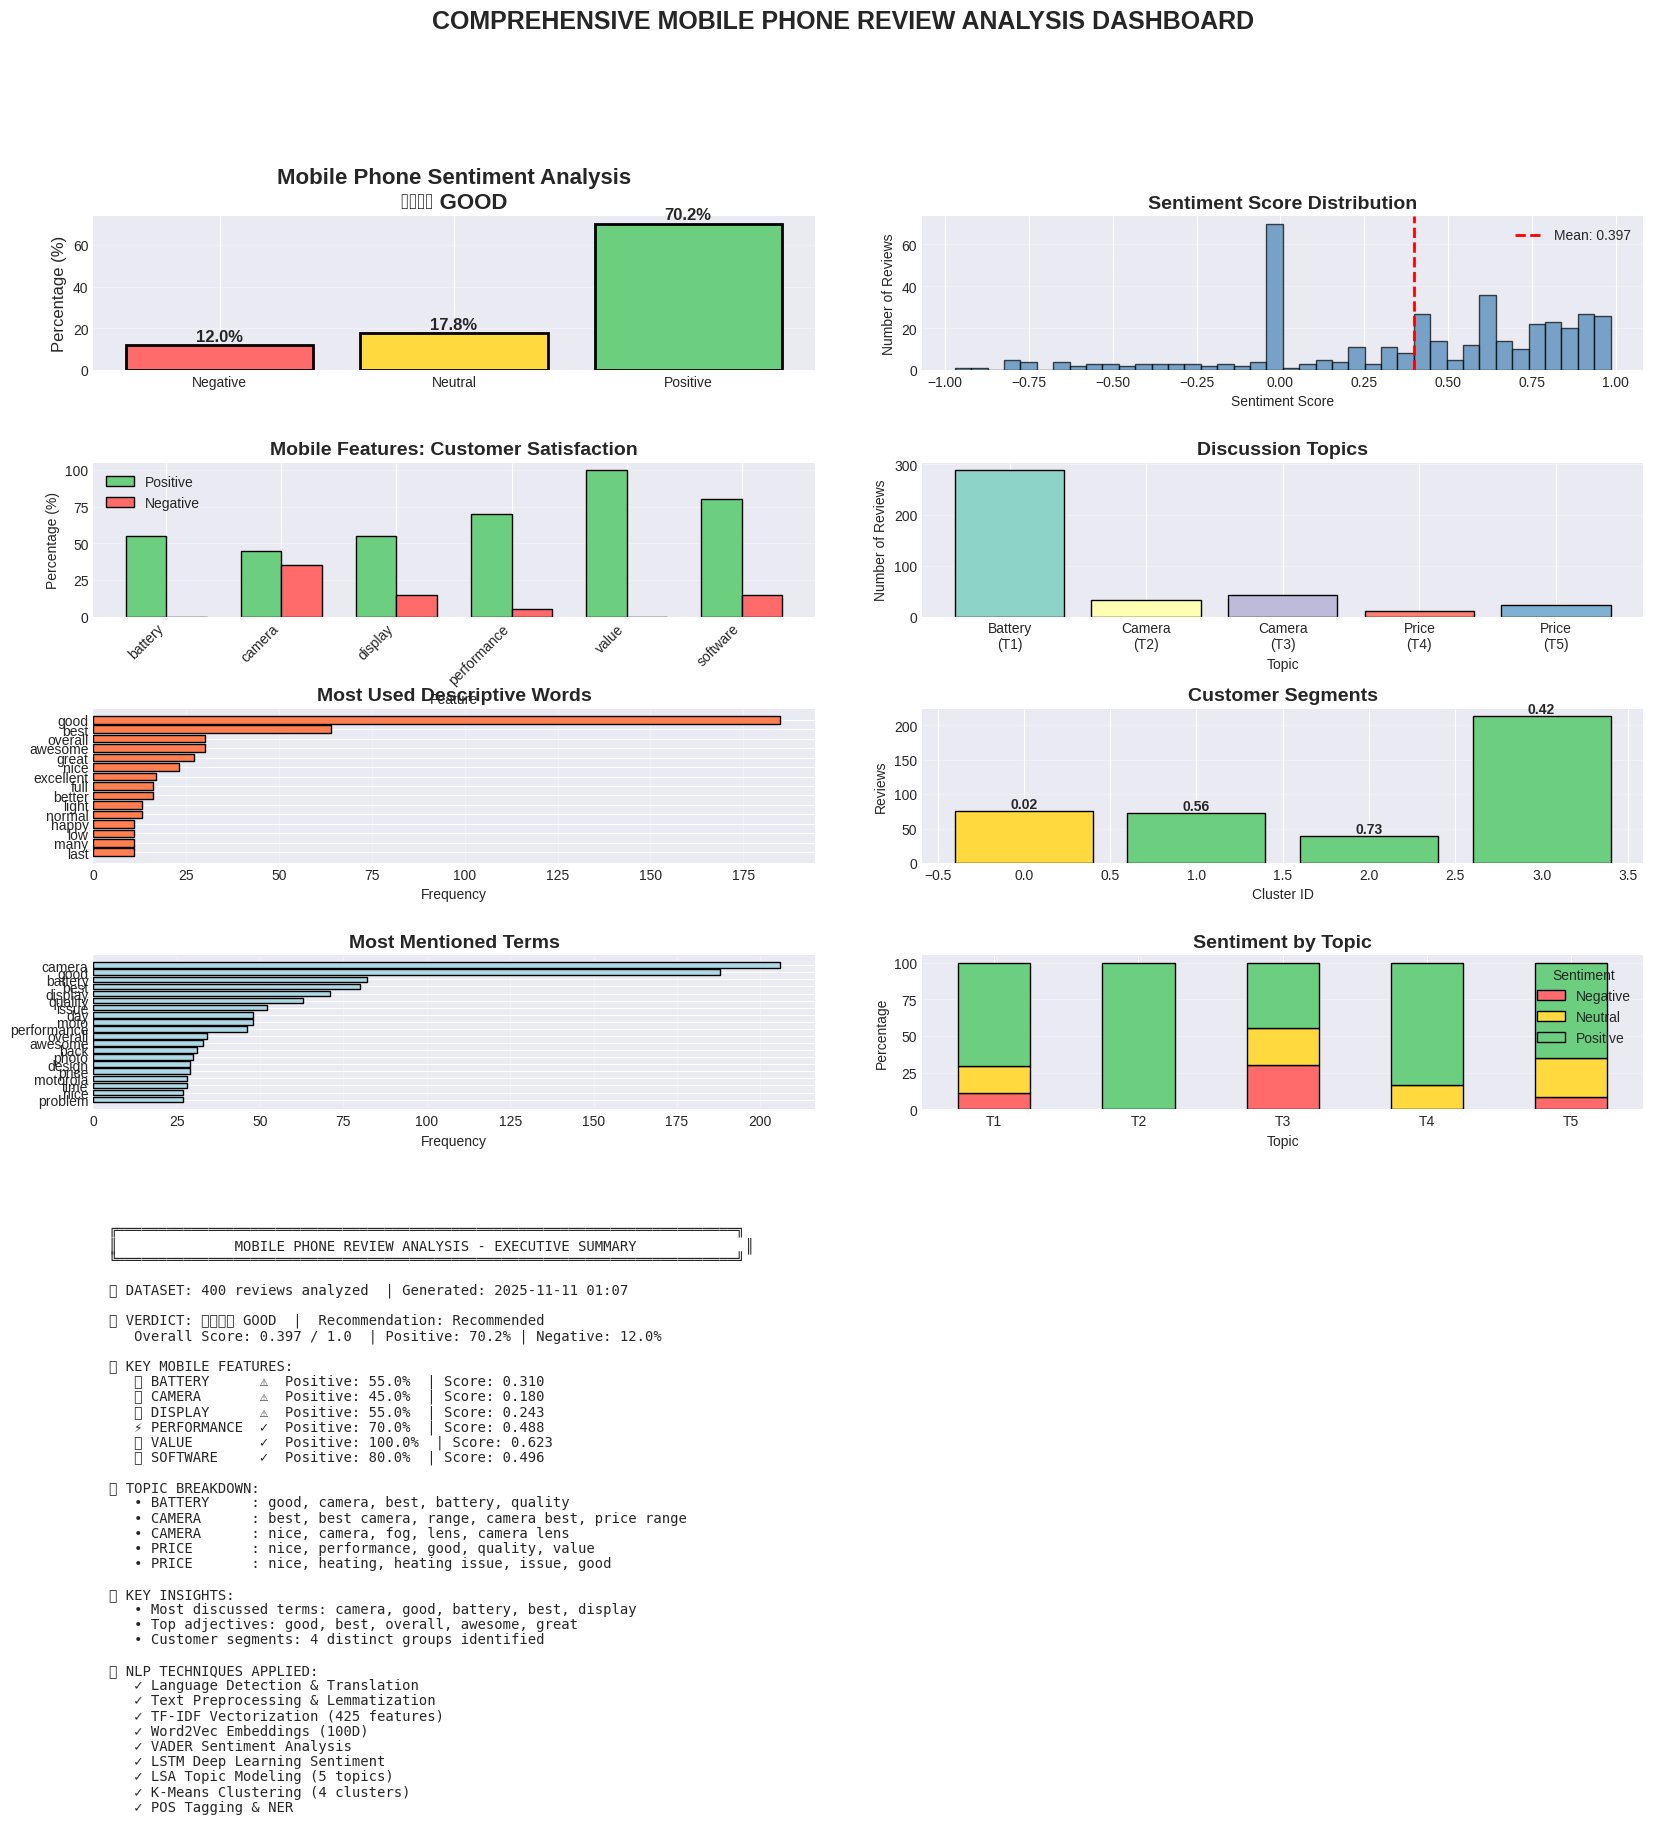

In [4]:
"""
COMPREHENSIVE MOBILE PHONE REVIEW ANALYSIS SYSTEM
Classical NLP Approach - Complete Pipeline
Built around working scraping code
"""

import requests
from bs4 import BeautifulSoup
import time
import random
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from datetime import datetime
import warnings
import pickle
import os

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*80)
print("MOBILE PHONE REVIEW ANALYSIS SYSTEM")
print("Classical NLP Pipeline for Customer Insights")
print("="*80)
print()

# =============================================================================
# CONFIGURATION
# =============================================================================

# Initialize flag
SKIP_SCRAPING = False

print("Choose data source:")
print("1. Scrape from Flipkart URL")
print("2. Load from existing CSV file")
data_source = input("Enter your choice (1 or 2): ").strip()

if data_source == '2':
    # Load from CSV
    csv_path = input("Enter the path to your CSV file: ").strip()

    try:
        df = pd.read_csv(csv_path, encoding='utf-8')

        # Try to identify the comment column
        possible_columns = ['Comment', 'comment', 'Review', 'review', 'Text', 'text', 'reviews', 'Comments']
        comment_column = None

        for col in possible_columns:
            if col in df.columns:
                comment_column = col
                break

        if comment_column is None:
            print(f"\nAvailable columns: {', '.join(df.columns)}")
            comment_column = input("Enter the name of the column containing reviews: ").strip()

        all_comments_list = df[comment_column].dropna().tolist()

        print(f"\n✓ Loaded {len(all_comments_list)} reviews from CSV")

        # Create output folder
        OUTPUT_FOLDER = "mobile_review_analysis"
        if not os.path.exists(OUTPUT_FOLDER):
            os.makedirs(OUTPUT_FOLDER)
            print(f"✓ Created output folder: {OUTPUT_FOLDER}\n")

        # Save to standard format
        df = pd.DataFrame({'Comment': all_comments_list})
        df.to_csv(f'{OUTPUT_FOLDER}/01_raw_reviews.csv', index=False, encoding='utf-8')
        print(f"✓ Raw reviews saved\n")

        # Skip scraping section
        SKIP_SCRAPING = True

    except FileNotFoundError:
        print(f"\n❌ File not found: {csv_path}")
        print("Please check the path and try again.")
        exit(1)
    except Exception as e:
        print(f"\n❌ Error loading CSV: {e}")
        exit(1)

else:
    # Original scraping workflow
    SKIP_SCRAPING = False

    # Get product URL from user
    product_url = input("Enter the Flipkart product URL: ").strip()
    max_pages = int(input("Enter number of pages to scrape (recommended 10-50): "))

    # Ask user for sort preference
    print("\nSort options:")
    print("1. Most Recent (MOST_RECENT)")
    print("2. Most Helpful (MOST_HELPFUL)")
    print("3. Positive First (POSITIVE_FIRST)")
    print("4. Negative First (NEGATIVE_FIRST)")
    sort_choice = input("Enter your choice (1-4) [default: 1 for Most Recent]: ").strip()

    sort_map = {
        '1': 'MOST_RECENT',
        '2': 'MOST_HELPFUL',
        '3': 'POSITIVE_FIRST',
        '4': 'NEGATIVE_FIRST',
        '': 'MOST_RECENT'  # Default
    }

    sort_order = sort_map.get(sort_choice, 'MOST_RECENT')
    print(f"✓ Selected sort order: {sort_order}\n")

    OUTPUT_FOLDER = "mobile_review_analysis"
    if not os.path.exists(OUTPUT_FOLDER):
        os.makedirs(OUTPUT_FOLDER)
        print(f"✓ Created output folder: {OUTPUT_FOLDER}\n")

# =============================================================================
# PHASE 1: DATA ACQUISITION - YOUR WORKING SCRAPING CODE
# =============================================================================

if not SKIP_SCRAPING:
    print("="*80)
    print("PHASE 1: DATA ACQUISITION")
    print("="*80)
    print("\n[1.1] Scraping Reviews from Flipkart...\n")

    # This list will store all the comments
    all_comments_list = []

    HEADERS = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }

    # Define the base URL *without* the page number
    BASE_REVIEW_URL = product_url.replace("/p/", "/product-reviews/")

    # Add sort order parameter if not already present
    if 'sortOrder=' not in BASE_REVIEW_URL:
        separator = '&' if '?' in BASE_REVIEW_URL else '?'
        BASE_REVIEW_URL = f"{BASE_REVIEW_URL}{separator}sortOrder={sort_order}"
    else:
        # Replace existing sortOrder parameter
        import re
        BASE_REVIEW_URL = re.sub(r'sortOrder=[^&]*', f'sortOrder={sort_order}', BASE_REVIEW_URL)

    print(f"Base URL: {BASE_REVIEW_URL}\n")

    # Loop through pages
    for page_num in range(1, max_pages + 1):

        # Build the URL for the exact page you want
        current_page_url = f"{BASE_REVIEW_URL}&page={page_num}"

        print(f"--- Scraping Page {page_num} ---")

        # Retry logic for 429 errors
        max_retries = 2
        retry_count = 0
        page_success = False

        while retry_count <= max_retries and not page_success:
            try:
                r = requests.get(current_page_url, headers=HEADERS)
                r.raise_for_status() # Check for errors like 404 or 503
                soup = BeautifulSoup(r.content, 'html.parser')

                # --- This is the comment scraping logic ---

                # Using your class name 'col EPCmJX Ma1fCG' for the review block
                comment_blocks = soup.find_all('div', class_='col EPCmJX Ma1fCG')
                print(f"Found {len(comment_blocks)} comments on this page.")

                if not comment_blocks:
                    print("No comments found, this might be the last page or classes changed.")
                    page_success = True
                    break

                # Loop to extract text from each comment block
                for block in comment_blocks:
                    # Using your class name 'ZmyHeo' for the text container
                    text_container = block.find('div', class_='ZmyHeo')
                    if text_container:
                        comment_div = text_container.find('div')
                        if comment_div:
                            comment_text = comment_div.get_text(strip=True)
                            if comment_text:
                                all_comments_list.append(comment_text)

                page_success = True

                # Wait before scraping the next page
                if page_num < max_pages:
                    sleep_time = random.uniform(2, 4)
                    print(f"Waiting for {sleep_time:.1f} seconds...")
                    time.sleep(sleep_time)

            except requests.exceptions.HTTPError as errh:
                if errh.response.status_code == 404:
                    print(f"Page {page_num} not found (404). This is the last page. Stopping loop.")
                    page_success = True
                    break
                elif errh.response.status_code == 429:
                    retry_count += 1
                    if retry_count <= max_retries:
                        wait_time = random.uniform(5, 10) * retry_count  # Exponential backoff
                        print(f"⚠ 429 Too Many Requests - Retry {retry_count}/{max_retries}. Waiting {wait_time:.1f} seconds...")
                        time.sleep(wait_time)
                    else:
                        print(f"❌ Failed after {max_retries} retries due to 429 error. Stopping.")
                        page_success = True
                        break
                else:
                    print(f"Http Error: {errh}")
                    break
            except requests.exceptions.RequestException as e:
                print(f"An error occurred: {e}")
                break

        # If we couldn't get the page after retries, break the loop
        if not page_success or (retry_count > max_retries):
            break

    # --- Final Results ---
    print("\n" + "="*80)
    print(f"✓ Scraping complete. Total comments found: {len(all_comments_list)}")
    print("="*80)

    if len(all_comments_list) == 0:
        print("\n❌ No reviews were collected. Please check the URL and try again.")
        exit(1)

    # Create DataFrame
    df = pd.DataFrame({'Comment': all_comments_list})
    df.to_csv(f'{OUTPUT_FOLDER}/01_raw_reviews.csv', index=False, encoding='utf-8')
    print(f"✓ Raw reviews saved\n")
else:
    print("="*80)
    print("PHASE 1: DATA LOADED FROM CSV")
    print("="*80)
    print()

# =============================================================================
# PHASE 1 CONTINUED: PREPROCESSING
# =============================================================================

print("[1.2] Installing and Loading NLP Libraries...")

# Install required packages
try:
    import nltk
    nltk.download('punkt', quiet=True)
    nltk.download('punkt_tab', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('averaged_perceptron_tagger_eng', quiet=True)
    nltk.download('omw-1.4', quiet=True)
    nltk.download('vader_lexicon', quiet=True)
    nltk.download('maxent_ne_chunker', quiet=True)
    nltk.download('words', quiet=True)
    print("✓ NLTK resources loaded")
except:
    print("! Some NLTK resources may be missing")

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

# Phase 1.2: Language Identification & Translation
# -----------------------------------------------------------------------------
print("\n[1.2] Language Detection & Translation...")

# Install libraries for translation (non-transformer based)
try:
    import langdetect
    from googletrans import Translator
    print("✓ Translation libraries loaded")
except ImportError:
    print("! 'langdetect' or 'googletrans' not found. Installing...")
    try:
        import subprocess
        import sys
        subprocess.check_call([sys.executable, "-m", "pip", "install", "langdetect", "googletrans==4.0.0-rc1", "-q"])
        import langdetect
        from googletrans import Translator
        print("✓ Translation libraries installed and loaded")
    except Exception as e:
        print(f"❌ Failed to install translation libraries: {e}")
        print("Skipping translation. Analysis may be inaccurate.")
        Translator = None

if 'Translator' in locals() and Translator is not None:
    translator = Translator()

    # Create a copy to store original comment
    df['Original_Comment'] = df['Comment']

    translated_count = 0
    total_reviews = len(df)

    for index, row in df.iterrows():
        comment = row['Comment']
        if pd.isna(comment) or comment.strip() == '':
            df.at[index, 'language'] = 'en'
            continue

        try:
            # 1. Detect Language
            lang = langdetect.detect(comment)
            df.at[index, 'language'] = lang

            # 2. Translate if not English
            if lang != 'en':
                try:
                    translated_text = translator.translate(comment, src=lang, dest='en').text
                    df.at[index, 'Comment'] = translated_text
                    translated_count += 1
                except Exception as e:
                    print(f"⚠ Warning: Could not translate review #{index}. Using original. Error: {e}")
                    # Keep original text if translation fails
                    pass

        except Exception as e:
            # langdetect fails on very short/numeric strings, assume 'en'
            df.at[index, 'language'] = 'en'

        if (index + 1) % 100 == 0:
            print(f"  ...processed {index+1}/{total_reviews} reviews")

    print(f"\n✓ Language processing complete. Translated {translated_count} non-English reviews.")
    df.to_csv(f'{OUTPUT_FOLDER}/01a_translated_reviews.csv', index=False, encoding='utf-8')
else:
    print("\n! Skipping language translation.")
    df['language'] = 'en' # Assume all are english
    df['Original_Comment'] = df['Comment']
# -----------------------------------------------------------------------------


print("\n[1.3] Text Cleaning & Preprocessing...")

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
# Add Flipkart-specific stopwords and common noise words
stop_words.update([
    'read', 'readmore', 'flipkart', 'product', 'review', 'phone', 'mobile',
    'oneread', 'phoneread', 'goodread', 'cameraread', 'moneyread', 'productread',
    'one', 'get', 'got', 'use', 'using', 'used', 'also', 'really', 'much',
    'go', 'thing', 'something', 'everything', 'anything', 'make', 'take'
])

# Words to filter out even if not stopwords (too generic for mobile reviews)
generic_words = {
    'is', 'are', 'am', 'was', 'were', 'be', 'been', 'being',
    'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could', 'should',
    's', 't', 'd', 'll', 've', 're', 'm'  # Contractions
}

def clean_text(text):
    """Clean and normalize text"""
    if pd.isna(text) or text == '':
        return ''
    text = str(text)
    text = re.sub(r'<.*?>', '', text)  # HTML
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # URLs
    text = re.sub(r'\S+@\S+', '', text)  # Emails
    text = re.sub(r'[^\w\s.,!?;:\'\"-]', ' ', text)  # Special chars
    # Remove common UI elements from Flipkart
    text = re.sub(r'\b(read more|readmore|read|more)\b', '', text, flags=re.IGNORECASE)
    # Remove patterns like "phoneread", "goodread", etc.
    text = re.sub(r'\b\w+read\b', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\breadone\b|\breadmore\b', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def preprocess_text(text):
    """Tokenize, remove stopwords, and lemmatize"""
    text = text.lower()
    tokens = word_tokenize(text)
    # Filter: alphanumeric, not stopwords, length > 2, not generic words
    tokens = [word for word in tokens
              if word.isalnum()
              and word not in stop_words
              and word not in generic_words
              and len(word) > 2]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

# Apply preprocessing
df['cleaned_text'] = df['Comment'].apply(clean_text)
df['normalized_text'] = df['cleaned_text'].str.lower()
df['lemmatized_tokens'] = df['normalized_text'].apply(preprocess_text)
df['processed_text'] = df['lemmatized_tokens'].apply(lambda x: ' '.join(x))

# Remove duplicates and empty reviews
initial_count = len(df)
df = df[df['processed_text'].str.strip() != '']
df = df.drop_duplicates(subset=['processed_text'], keep='first')
df = df.reset_index(drop=True)

print(f"✓ Cleaned {initial_count} → {len(df)} reviews (removed {initial_count - len(df)} duplicates/empty)")
df.to_csv(f'{OUTPUT_FOLDER}/02_cleaned_reviews.csv', index=False, encoding='utf-8')

# =============================================================================
# PHASE 2: SYNTACTIC & SEMANTIC ANALYSIS
# =============================================================================

print("\n" + "="*80)
print("PHASE 2: SYNTACTIC & SEMANTIC ANALYSIS")
print("="*80)

# --- POS Tagging ---
print("\n[2.1] Part-of-Speech Tagging...")

df['pos_tags'] = df['normalized_text'].apply(lambda x: pos_tag(word_tokenize(x)) if x else [])

all_pos_tags = []
for tags in df['pos_tags']:
    if isinstance(tags, list):
        all_pos_tags.extend(tags)

adjectives = [word for word, tag in all_pos_tags
              if tag in ['JJ', 'JJR', 'JJS']
              and word not in stop_words
              and word not in generic_words
              and len(word) > 2]
verbs = [word for word, tag in all_pos_tags
         if tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
         and word not in stop_words
         and word not in generic_words
         and word not in ['is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had']
         and len(word) > 2]
nouns = [word for word, tag in all_pos_tags
         if tag in ['NN', 'NNS', 'NNP', 'NNPS']
         and word not in stop_words
         and word not in generic_words
         and len(word) > 2]

adjective_freq = Counter(adjectives)
verb_freq = Counter(verbs)
noun_freq = Counter(nouns)

print(f"✓ Top adjectives: {', '.join([w for w, c in adjective_freq.most_common(8)])}")
print(f"✓ Top verbs: {', '.join([w for w, c in verb_freq.most_common(8)])}")

# --- Named Entity Recognition ---
print("\n[2.2] Named Entity Recognition...")

try:
    import spacy
    try:
        nlp = spacy.load('en_core_web_sm')

        def extract_entities(text):
            if pd.isna(text) or text == '':
                return []
            doc = nlp(str(text)[:100000])
            return [(ent.text, ent.label_) for ent in doc.ents]

        df['named_entities'] = df['normalized_text'].apply(extract_entities)

        all_entities = []
        for entities in df['named_entities']:
            if isinstance(entities, list):
                all_entities.extend(entities)

        print(f"✓ Found {len(all_entities)} entities")
    except:
        print("! spaCy model not found. Skipping NER.")
        df['named_entities'] = [[] for _ in range(len(df))]
except ImportError:
    print("! spaCy not installed. Skipping NER.")
    df['named_entities'] = [[] for _ in range(len(df))]

# --- TF-IDF Vectorization ---
print("\n[2.3] TF-IDF Vectorization...")

from sklearn.feature_extraction.text import TfidfVectorizer

texts = df['processed_text'].fillna('').tolist()
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,
    min_df=3,  # Word must appear in at least 3 documents
    max_df=0.7,  # Ignore words appearing in >70% of documents
    ngram_range=(1, 2)  # Include bigrams for better context
)
tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

print(f"✓ TF-IDF matrix: {tfidf_matrix.shape}")

with open(f'{OUTPUT_FOLDER}/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
np.save(f'{OUTPUT_FOLDER}/tfidf_matrix.npy', tfidf_matrix.toarray())

# --- Word2Vec Embeddings ---
print("\n[2.4] Training Word2Vec Model...")

try:
    from gensim.models import Word2Vec

    sentences = [tokens for tokens in df['lemmatized_tokens'] if len(tokens) > 0]

    word2vec_model = Word2Vec(
        sentences=sentences,
        vector_size=100,
        window=5,
        min_count=2,
        workers=4,
        sg=0,
        epochs=10
    )

    print(f"✓ Word2Vec trained. Vocabulary: {len(word2vec_model.wv)}")
    word2vec_model.save(f'{OUTPUT_FOLDER}/word2vec_model.bin')

    # Mobile-specific tests
    mobile_keywords = ['battery', 'camera', 'display', 'performance', 'price']

    # Phase 2.5: Vector Semantics & Similarity (from PDF)
    w2v_similar_words = {} # Store results for report
    print("✓ Testing mobile keywords for similarity:")
    for keyword in mobile_keywords:
        if keyword in word2vec_model.wv:
            # Find top 5 similar words
            similar = word2vec_model.wv.most_similar(keyword, topn=5)
            similar_words_list = [w for w, s in similar]
            print(f"  '{keyword}' → {', '.join(similar_words_list)}")
            w2v_similar_words[keyword] = similar_words_list
        else:
            print(f"  '{keyword}' → Not in vocabulary")
            w2v_similar_words[keyword] = ["N/A"]

except ImportError:
    print("! Gensim not installed. Skipping Word2Vec.")
    word2vec_model = None
    w2v_similar_words = {} # Create empty dict

# --- Sentiment Analysis (VADER) ---
print("\n[2.5] Sentiment Analysis - VADER...")

try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

    vader = SentimentIntensityAnalyzer()

    def get_vader_sentiment(text):
        if pd.isna(text) or text == '':
            return {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}
        return vader.polarity_scores(str(text))

    df['vader_scores'] = df['normalized_text'].apply(get_vader_sentiment)
    df['vader_compound'] = df['vader_scores'].apply(lambda x: x['compound'])
    df['vader_sentiment'] = df['vader_compound'].apply(
        lambda x: 'Positive' if x >= 0.05 else ('Negative' if x <= -0.05 else 'Neutral')
    )

    sentiment_dist = df['vader_sentiment'].value_counts()
    print(f"✓ Sentiment: {sentiment_dist.to_dict()}")
    print(f"✓ Average score: {df['vader_compound'].mean():.3f}")

except ImportError:
    print("! VADER not installed. Installing now...")
    try:
        import subprocess
        import sys
        subprocess.check_call([sys.executable, "-m", "pip", "install", "vaderSentiment", "-q"])
        print("✓ VADER installed successfully. Retrying...")

        from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

        vader = SentimentIntensityAnalyzer()

        def get_vader_sentiment(text):
            if pd.isna(text) or text == '':
                return {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}
            return vader.polarity_scores(str(text))

        df['vader_scores'] = df['normalized_text'].apply(get_vader_sentiment)
        df['vader_compound'] = df['vader_scores'].apply(lambda x: x['compound'])
        df['vader_sentiment'] = df['vader_compound'].apply(
            lambda x: 'Positive' if x >= 0.05 else ('Negative' if x <= -0.05 else 'Neutral')
        )

        sentiment_dist = df['vader_sentiment'].value_counts()
        print(f"✓ Sentiment: {sentiment_dist.to_dict()}")
        print(f"✓ Average score: {df['vader_compound'].mean():.3f}")
    except:
        print("! Could not install VADER. Using neutral sentiment.")
        df['vader_compound'] = 0
        df['vader_sentiment'] = 'Neutral'

# --- LSTM Sentiment Analysis ---
print("\n[2.6] Sentiment Analysis - LSTM...")

try:
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
    from tensorflow.keras.preprocessing.text import Tokenizer as KerasTokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    from sklearn.model_selection import train_test_split

    MAX_WORDS = 5000
    MAX_LEN = 100

    def vader_to_numeric(sentiment):
        return 2 if sentiment == 'Positive' else (0 if sentiment == 'Negative' else 1)

    df['sentiment_label'] = df['vader_sentiment'].apply(vader_to_numeric)
    labels = df['sentiment_label'].values

    keras_tokenizer = KerasTokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
    keras_tokenizer.fit_on_texts(texts)
    sequences = keras_tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

    X_train, X_test, y_train, y_test = train_test_split(
        padded, labels, test_size=0.2, random_state=42, stratify=labels
    )

    model = Sequential([
        Embedding(MAX_WORDS, 128, input_length=MAX_LEN),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.5),
        Bidirectional(LSTM(32)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    print("  Training LSTM (this may take a few minutes)...")
    history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=0)

    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"✓ LSTM trained. Test accuracy: {test_accuracy:.3f}")

    all_predictions = model.predict(padded, verbose=0)
    df['lstm_sentiment_class'] = np.argmax(all_predictions, axis=1)
    df['lstm_sentiment'] = df['lstm_sentiment_class'].apply(
        lambda x: ['Negative', 'Neutral', 'Positive'][x]
    )

    model.save(f'{OUTPUT_FOLDER}/lstm_model.keras')
    with open(f'{OUTPUT_FOLDER}/lstm_tokenizer.pkl', 'wb') as f:
        pickle.dump(keras_tokenizer, f)

except ImportError:
    print("! TensorFlow not installed. Skipping LSTM.")
    df['lstm_sentiment'] = df['vader_sentiment']

# --- Topic Modeling (LSA) ---
print("\n[2.7] Topic Modeling - LSA...")

from sklearn.decomposition import TruncatedSVD

n_topics = 5
lsa_model = TruncatedSVD(n_components=n_topics, random_state=42)
lsa_matrix = lsa_model.fit_transform(tfidf_matrix)

feature_names = tfidf_vectorizer.get_feature_names_out()

# Mobile aspect mapping - Enhanced with more specific terms
mobile_aspects = {
    'battery': ['battery', 'charge', 'charging', 'backup', 'power', 'drain', 'mah', 'charger', 'charging'],
    'camera': ['camera', 'photo', 'picture', 'video', 'lens', 'photography', 'selfie', 'portrait', 'pixel', 'clarity'],
    'display': ['display', 'screen', 'brightness', 'color', 'resolution', 'amoled', 'lcd', 'refresh', 'touch'],
    'performance': ['performance', 'speed', 'fast', 'lag', 'processor', 'ram', 'gaming', 'multitasking', 'smooth', 'slow'],
    'build': ['build', 'quality', 'design', 'premium', 'material', 'plastic', 'metal', 'glass', 'finish'],
    'price': ['price', 'value', 'money', 'worth', 'cost', 'expensive', 'cheap', 'budget', 'affordable'],
    'software': ['software', 'update', 'android', 'ui', 'interface', 'app', 'bloatware', 'os'],
    'audio': ['audio', 'sound', 'speaker', 'music', 'volume', 'headphone', 'bass']
}

print(f"✓ Identified {n_topics} topics:")
topics_info = []

for topic_idx, topic in enumerate(lsa_model.components_):
    top_indices = topic.argsort()[-15:][::-1]  # Get top 15 instead of 10
    top_words = [feature_names[i] for i in top_indices]

    # Filter out remaining noise words
    top_words = [w for w in top_words
                 if w not in stop_words
                 and w not in generic_words
                 and not w.endswith('read')
                 and len(w) > 2][:10]  # Keep top 10 after filtering

    # Match to mobile aspect with better scoring
    aspect_match = 'general'
    max_overlap = 0
    for aspect, keywords in mobile_aspects.items():
        overlap = len(set(top_words) & set(keywords))
        # Also check for partial matches in bigrams
        partial_matches = sum(1 for word in top_words if any(kw in word for kw in keywords))
        total_score = overlap + (partial_matches * 0.5)

        if total_score > max_overlap:
            max_overlap = total_score
            aspect_match = aspect

    topics_info.append({
        'topic_id': topic_idx,
        'aspect': aspect_match,
        'keywords': top_words[:7]
    })

    print(f"  Topic {topic_idx+1} ({aspect_match}): {', '.join(top_words[:6])}")

df['dominant_topic'] = np.argmax(lsa_matrix, axis=1)

# =============================================================================
# PHASE 3: ADVANCED ANALYSIS
# =============================================================================

print("\n" + "="*80)
print("PHASE 3: ADVANCED ANALYSIS & INSIGHTS")
print("="*80)

# --- Clustering ---
print("\n[3.1] Clustering Reviews...")

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

# Determine optimal number of clusters (3-7 based on dataset size)
n_clusters = min(max(3, len(df) // 100), 7)
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10, max_iter=300)
df['cluster'] = kmeans.fit_predict(tfidf_matrix)

similarity_matrix = cosine_similarity(tfidf_matrix)
df['avg_similarity'] = similarity_matrix.mean(axis=1)

print(f"✓ Created {n_clusters} clusters")


# Phase 3.1: Review Summarization using Similarity Index (from PDF)
# -----------------------------------------------------------------------------
print("\n[3.1] Finding Representative Reviews from Clusters...")

representative_reviews = []
cluster_centroids = kmeans.cluster_centers_

for i in range(n_clusters):
    # Get all reviews in the current cluster
    cluster_mask = (df['cluster'] == i)
    cluster_indices = df[cluster_mask].index
    # Corrected: Use .iloc to get rows by index from the sparse matrix
    cluster_tfidf_matrix = tfidf_matrix[cluster_indices]

    if cluster_tfidf_matrix.shape[0] == 0:
        continue # Skip empty clusters

    # Get the centroid for this cluster
    centroid_vector = cluster_centroids[i].reshape(1, -1)

    # Calculate cosine similarity between centroid and all reviews in this cluster
    sims = cosine_similarity(cluster_tfidf_matrix, centroid_vector)

    # Find the index of the review with the highest similarity (closest to centroid)
    closest_review_index_in_cluster = np.argmax(sims)
    original_df_index = cluster_indices[closest_review_index_in_cluster]

    # Get the review details
    rep_review = df.loc[original_df_index] # Use .loc for label-based indexing

    representative_reviews.append({
        'cluster_id': i,
        'original_index': original_df_index,
        'original_comment': rep_review['Original_Comment'],
        'processed_text': rep_review['processed_text'],
        'sentiment': rep_review['vader_sentiment'],
        'sentiment_score': rep_review['vader_compound'],
        'topic': topics_info[rep_review['dominant_topic']]['aspect']
    })

print(f"✓ Found {len(representative_reviews)} representative reviews, one for each cluster.")
# -----------------------------------------------------------------------------


# --- Mobile Feature Q&A ---
print("\n[3.2] Mobile Feature Analysis...")

### MODIFIED CODE ###
# Added a 6th question about Software/UI
mobile_questions = [
    {"question": "How is the battery life?", "keywords": ["battery", "charge", "charging", "backup", "power"], "context": "battery"},
    {"question": "Is the camera good?", "keywords": ["camera", "photo", "picture", "video", "lens"], "context": "camera"},
    {"question": "How is the display?", "keywords": ["display", "screen", "brightness", "color"], "context": "display"},
    {"question": "Is performance good?", "keywords": ["performance", "speed", "fast", "lag", "gaming"], "context": "performance"},
    {"question": "Is it value for money?", "keywords": ["price", "value", "money", "worth", "cost"], "context": "value"},
    {"question": "How is the software (UI)?", "keywords": ["software", "ui", "android", "update", "bloatware", "os"], "context": "software"}
]

qa_results = []

for q_data in mobile_questions:
    keywords = q_data['keywords']
    query = ' '.join(keywords)
    query_vector = tfidf_vectorizer.transform([query])
    similarities = cosine_similarity(query_vector, tfidf_matrix).flatten()

    top_indices = similarities.argsort()[-20:][::-1]
    relevant_reviews = df.iloc[top_indices]

    if len(relevant_reviews) > 0:
        positive = len(relevant_reviews[relevant_reviews['vader_sentiment'] == 'Positive'])
        negative = len(relevant_reviews[relevant_reviews['vader_sentiment'] == 'Negative'])
        total = len(relevant_reviews)
        avg_score = relevant_reviews['vader_compound'].mean()

        qa_results.append({
            'question': q_data['question'],
            'context': q_data['context'],
            'positive_pct': (positive / total) * 100,
            'negative_pct': (negative / total) * 100,
            'avg_score': avg_score
        })

qa_df = pd.DataFrame(qa_results)
print(f"✓ Analyzed {len(qa_results)} mobile features")

### NEW CODE ###
# Print the Q&A results directly to the console
print("\n[3.2] SIMULATED Q&A RESULTS:")
print("-" * 40)
if len(qa_df) > 0:
    for _, row in qa_df.iterrows():
        print(f"Q: {row['question']}")
        if row['avg_score'] > 0.3:
            answer = f"A: Very Positive. (Score: {row['avg_score']:.2f})"
        elif row['avg_score'] > 0:
            answer = f"A: Mixed/Neutral. (Score: {row['avg_score']:.2f})"
        else:
            answer = f"A: Mostly Negative. (Score: {row['avg_score']:.2f})"
        print(answer)
        print(f"   (Based on {row['positive_pct']:.0f}% positive reviews)\n")
print("-" * 40)
### END NEW CODE ###

# --- Save Final Data ---
df.to_csv(f'{OUTPUT_FOLDER}/03_final_analyzed_reviews.csv', index=False, encoding='utf-8')
qa_df.to_csv(f'{OUTPUT_FOLDER}/04_mobile_feature_qa.csv', index=False)

# =============================================================================
# VISUALIZATION & REPORTING
# =============================================================================

print("\n" + "="*80)
print("GENERATING VISUALIZATIONS & REPORTS")
print("="*80)

overall_sentiment = df['vader_compound'].mean()
positive_pct = (len(df[df['vader_sentiment'] == 'Positive']) / len(df)) * 100
negative_pct = (len(df[df['vader_sentiment'] == 'Negative']) / len(df)) * 100
neutral_pct = 100 - positive_pct - negative_pct

# Determine verdict
if overall_sentiment > 0.5:
    verdict = "⭐⭐⭐⭐⭐ EXCELLENT"
    recommendation = "Highly Recommended"
elif overall_sentiment > 0.2:
    verdict = "⭐⭐⭐⭐ GOOD"
    recommendation = "Recommended"
elif overall_sentiment > 0:
    verdict = "⭐⭐⭐ AVERAGE"
    recommendation = "Consider with Caution"
else:
    verdict = "⭐⭐ BELOW AVERAGE"
    recommendation = "Not Recommended"

# Create Dashboard
fig = plt.figure(figsize=(20, 18)) # Increased height
gs = fig.add_gridspec(6, 4, hspace=0.6, wspace=0.35) # 6 rows, more hspace

# 1. Sentiment Distribution
ax1 = fig.add_subplot(gs[0, :2])
categories = ['Negative', 'Neutral', 'Positive']
values = [negative_pct, neutral_pct, positive_pct]
colors = ['#ff6b6b', '#ffd93d', '#6bcf7f']
ax1.bar(categories, values, color=colors, edgecolor='black', linewidth=2)
ax1.set_title(f'Mobile Phone Sentiment Analysis\n{verdict}', fontsize=16, fontweight='bold')
ax1.set_ylabel('Percentage (%)', fontsize=12)
for i, v in enumerate(values):
    ax1.text(i, v + 2, f'{v:.1f}%', ha='center', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# 2. Sentiment Score Distribution
ax2 = fig.add_subplot(gs[0, 2:])
ax2.hist(df['vader_compound'], bins=40, color='steelblue', edgecolor='black', alpha=0.7)
ax2.axvline(overall_sentiment, color='red', linestyle='--', linewidth=2, label=f'Mean: {overall_sentiment:.3f}')
ax2.set_title('Sentiment Score Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Sentiment Score')
ax2.set_ylabel('Number of Reviews')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Mobile Feature Analysis
ax3 = fig.add_subplot(gs[1, :2])
if len(qa_df) > 0:
    aspects = qa_df['context'].tolist()
    pos_pcts = qa_df['positive_pct'].tolist()
    neg_pcts = qa_df['negative_pct'].tolist()

    x = np.arange(len(aspects))
    width = 0.35

    ax3.bar(x - width/2, pos_pcts, width, label='Positive', color='#6bcf7f', edgecolor='black')
    ax3.bar(x + width/2, neg_pcts, width, label='Negative', color='#ff6b6b', edgecolor='black')

    ax3.set_title('Mobile Features: Customer Satisfaction', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Feature')
    ax3.set_ylabel('Percentage (%)')
    ax3.set_xticks(x)
    ax3.set_xticklabels(aspects, rotation=45, ha='right')
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)

# 4. Topic Distribution
ax4 = fig.add_subplot(gs[1, 2:])
topic_dist = df['dominant_topic'].value_counts().sort_index()
topic_labels = [f"{topics_info[i]['aspect'].title()}\n(T{i+1})" for i in range(min(len(topics_info), len(topic_dist)))]
colors_topic = plt.cm.Set3(range(len(topic_dist)))
ax4.bar(range(len(topic_dist)), topic_dist.values, color=colors_topic, edgecolor='black')
ax4.set_title('Discussion Topics', fontsize=14, fontweight='bold')
ax4.set_xlabel('Topic')
ax4.set_ylabel('Number of Reviews')
ax4.set_xticks(range(len(topic_dist)))
ax4.set_xticklabels(topic_labels[:len(topic_dist)], fontsize=10) # Increased font
ax4.grid(axis='y', alpha=0.3)

# 5. Top Adjectives
ax5 = fig.add_subplot(gs[2, :2])
top_adj = dict(adjective_freq.most_common(15))
ax5.barh(list(top_adj.keys()), list(top_adj.values()), color='coral', edgecolor='black')
ax5.set_title('Most Used Descriptive Words', fontsize=14, fontweight='bold')
ax5.set_xlabel('Frequency')
ax5.invert_yaxis()
ax5.grid(axis='x', alpha=0.3)

# 6. Cluster Analysis
ax6 = fig.add_subplot(gs[2, 2:])
cluster_sentiments = []
for cid in range(n_clusters):
    cluster_sentiments.append(df[df['cluster'] == cid]['vader_compound'].mean())
colors_cluster = ['#6bcf7f' if s > 0.2 else '#ffd93d' if s > -0.2 else '#ff6b6b' for s in cluster_sentiments]
bars = ax6.bar(range(n_clusters), df['cluster'].value_counts().sort_index().values, color=colors_cluster, edgecolor='black')
ax6.set_title('Customer Segments', fontsize=14, fontweight='bold')
ax6.set_xlabel('Cluster ID')
ax6.set_ylabel('Reviews')
ax6.grid(axis='y', alpha=0.3)
for i, (bar, sent) in enumerate(zip(bars, cluster_sentiments)):
    ax6.text(bar.get_x() + bar.get_width()/2., bar.get_height(), f'{sent:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold') # Increased font

# 7. Word Frequency
ax7 = fig.add_subplot(gs[3, :2])
all_words = []
for tokens in df['lemmatized_tokens']:
    all_words.extend(tokens)
word_freq = Counter(all_words)
top_words = dict(word_freq.most_common(20))
ax7.barh(list(top_words.keys()), list(top_words.values()), color='lightblue', edgecolor='black')
ax7.set_title('Most Mentioned Terms', fontsize=14, fontweight='bold')
ax7.set_xlabel('Frequency')
ax7.invert_yaxis()
ax7.grid(axis='x', alpha=0.3)

# 8. Sentiment by Topic
ax8 = fig.add_subplot(gs[3, 2:])
sent_by_topic = pd.crosstab(df['dominant_topic'], df['vader_sentiment'], normalize='index') * 100
sent_by_topic.plot(kind='bar', stacked=True, ax=ax8, color=['#ff6b6b', '#ffd93d', '#6bcf7f'], edgecolor='black')
ax8.set_title('Sentiment by Topic', fontsize=14, fontweight='bold')
ax8.set_xlabel('Topic')
ax8.set_ylabel('Percentage')
ax8.set_xticklabels([f'T{i+1}' for i in range(len(sent_by_topic))], rotation=0)
ax8.legend(title='Sentiment')
ax8.grid(axis='y', alpha=0.3)

# 9. Summary Text
ax9 = fig.add_subplot(gs[4:, :]) # Changed to span rows 4 and 5
ax9.axis('off')

summary_text = f"""
╔══════════════════════════════════════════════════════════════════════════╗
║              MOBILE PHONE REVIEW ANALYSIS - EXECUTIVE SUMMARY             ║
╚══════════════════════════════════════════════════════════════════════════╝

📊 DATASET: {len(df)} reviews analyzed  | Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')}

🎯 VERDICT: {verdict}  |  Recommendation: {recommendation}
   Overall Score: {overall_sentiment:.3f} / 1.0  | Positive: {positive_pct:.1f}% | Negative: {negative_pct:.1f}%

📱 KEY MOBILE FEATURES:
"""

# Add feature analysis
if len(qa_df) > 0:
    for _, row in qa_df.iterrows():
        feature_emoji = {
            'battery': '🔋',
            'camera': '📷',
            'display': '📺',
            'performance': '⚡',
            'value': '💰',
            'software': '🤖' # Added emoji for new question
        }.get(row['context'], '📱')

        feature_status = '✓' if row['positive_pct'] > 60 else ('⚠' if row['positive_pct'] > 40 else '✗')
        summary_text += f"   {feature_emoji} {row['context'].upper():12s} {feature_status}  Positive: {row['positive_pct']:.1f}%  | Score: {row['avg_score']:.3f}\n"

summary_text += f"""
🔍 TOPIC BREAKDOWN:
"""
for topic in topics_info[:5]:
    summary_text += f"   • {topic['aspect'].upper():12s}: {', '.join(topic['keywords'][:5])}\n"

summary_text += f"""
💡 KEY INSIGHTS:
   • Most discussed terms: {', '.join([w for w, c in word_freq.most_common(5)])}
   • Top adjectives: {', '.join([w for w, c in adjective_freq.most_common(5)])}
   • Customer segments: {n_clusters} distinct groups identified

📈 NLP TECHNIQUES APPLIED:
   ✓ Language Detection & Translation
   ✓ Text Preprocessing & Lemmatization
   ✓ TF-IDF Vectorization ({tfidf_matrix.shape[1]} features)
   ✓ Word2Vec Embeddings (100D)
   ✓ VADER Sentiment Analysis
   ✓ LSTM Deep Learning Sentiment
   ✓ LSA Topic Modeling ({n_topics} topics)
   ✓ K-Means Clustering ({n_clusters} clusters)
   ✓ POS Tagging & NER
"""

### MODIFIED CODE ###
# This block replaces the single ax9.text() call.
# We now split the summary_text into lines and plot them one by one
# to prevent the text from overlapping.

# Start plotting text from the top-left of the axis
y_pos = 0.95
line_height = 0.038  # Adjust this value to increase/decrease line spacing

# Split the text by newline characters
lines = summary_text.strip().split('\n')

for line in lines:
    # Plot each line separately
    ax9.text(
        0.01,  # x-position (1% from left)
        y_pos,  # y-position
        line,
        ha='left',  # Horizontal alignment
        va='top',  # Vertical alignment
        fontsize=10,
        family='monospace'  # Monospace font for report-style alignment
    )
    # Move the y-position down for the next line
    y_pos -= line_height

### END MODIFIED CODE ###


plt.suptitle('COMPREHENSIVE MOBILE PHONE REVIEW ANALYSIS DASHBOARD',
             fontsize=18, fontweight='bold', y=0.995)

plt.savefig(f'{OUTPUT_FOLDER}/05_analysis_dashboard.png', dpi=300, bbox_inches='tight')
print(f"✓ Dashboard saved: {OUTPUT_FOLDER}/05_analysis_dashboard.png")
### END MODIFIED CODE ###

# =============================================================================
# GENERATE TEXT REPORT
# =============================================================================

print("\n[4.2] Generating Text Report...")

# Added Word Similarity and updated Methodology
report = f"""
{'='*80}
MOBILE PHONE REVIEW ANALYSIS - COMPREHENSIVE REPORT
{'='*80}

ANALYSIS DATE: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
TOTAL REVIEWS ANALYZED: {len(df)}
SOURCE: {'CSV File' if SKIP_SCRAPING else product_url}

{'='*80}
1. EXECUTIVE SUMMARY
{'='*80}

OVERALL VERDICT: {verdict}
RECOMMENDATION: {recommendation}

Overall Sentiment Score: {overall_sentiment:.3f} / 1.0
   • Positive Reviews: {positive_pct:.1f}% ({len(df[df['vader_sentiment'] == 'Positive'])})
  • Neutral Reviews:  {neutral_pct:.1f}% ({len(df[df['vader_sentiment'] == 'Neutral'])})
  • Negative Reviews: {negative_pct:.1f}% ({len(df[df['vader_sentiment'] == 'Negative'])})

{'='*80}
2. MOBILE FEATURE ANALYSIS (SIMULATED Q&A)
{'='*80}
"""

if len(qa_df) > 0:
    for _, row in qa_df.iterrows():
        report += f"\n{row['context'].upper()} - {row['question']}\n"
        report += f"  Sentiment Score: {row['avg_score']:.3f}\n"
        report += f"  Positive: {row['positive_pct']:.1f}%  | Negative: {row['negative_pct']:.1f}%\n"

        if row['avg_score'] > 0.3:
            report += f"  Assessment: Customers are satisfied with {row['context']}\n"
        elif row['avg_score'] > 0:
            report += f"  Assessment: Mixed reviews about {row['context']}\n"
        else:
            report += f"  Assessment: Customers have concerns about {row['context']}\n"

report += f"""
{'='*80}
3. TOPIC ANALYSIS (LSA)
{'='*80}

Identified {n_topics} major discussion topics:
"""

for i, topic in enumerate(topics_info):
    report += f"\nTopic {i+1}: {topic['aspect'].upper()}\n"
    report += f"  Keywords: {', '.join(topic['keywords'])}\n"
    topic_reviews = df[df['dominant_topic'] == i]
    topic_sentiment = topic_reviews['vader_compound'].mean()
    report += f"  Reviews: {len(topic_reviews)} | Avg Sentiment: {topic_sentiment:.3f}\n"

report += f"""
{'='*80}
4. LINGUISTIC & SEMANTIC ANALYSIS
{'='*80}

TOP ADJECTIVES (Descriptive Words):
  {', '.join([f'{word} ({count})' for word, count in adjective_freq.most_common(15)])}

TOP VERBS (Action Words):
  {', '.join([f'{word} ({count})' for word, count in verb_freq.most_common(15)])}

TOP NOUNS (Key Subjects):
  {', '.join([f'{word} ({count})' for word, count in noun_freq.most_common(15)])}

SEMANTIC WORD SIMILARITY (from Word2Vec):
"""
for keyword, similar_list in w2v_similar_words.items():
    report += f"  • {keyword} → {', '.join(similar_list)}\n"

report += f"""
{'='*80}
5. CUSTOMER SEGMENTATION (K-MEANS)
{'='*80}

Identified {n_clusters} distinct customer segments through clustering:
"""

for cid in range(n_clusters):
    cluster_reviews = df[df['cluster'] == cid]
    cluster_sent = cluster_reviews['vader_compound'].mean()
    cluster_size = len(cluster_reviews)

    report += f"\nSegment {cid+1}:\n"
    report += f"  Size: {cluster_size} reviews ({cluster_size/len(df)*100:.1f}%)\n"
    report += f"  Avg Sentiment: {cluster_sent:.3f}\n"
    report += f"  Dominant Topics: {', '.join([topics_info[t]['aspect'] for t in cluster_reviews['dominant_topic'].value_counts().head(3).index])}\n"

report += f"""
{'='*80}
6. NLP METHODOLOGY
{'='*80}

This analysis employed multiple classical NLP techniques:

PREPROCESSING:
  • Language Detection & Translation (for non-English reviews)
  • Text cleaning (HTML, URLs, special characters removal)
  • Tokenization using NLTK
  • Stopword removal
  • Lemmatization for word normalization
  • Duplicate removal

SYNTACTIC ANALYSIS:
  • Part-of-Speech (POS) tagging
  • Named Entity Recognition (NER) using SpaCy (non-Transformer)

SEMANTIC ANALYSIS:
  • TF-IDF vectorization ({tfidf_matrix.shape[1]} features extracted)
  • Word2Vec embeddings (100-dimensional vectors)
  • LSA topic modeling ({n_topics} latent topics)

SENTIMENT ANALYSIS:
  • VADER (Valence Aware Dictionary and sEntiment Reasoner)
  • Bidirectional LSTM deep learning model
  • Both lexicon-based and neural approaches combined

CLUSTERING & SIMILARITY:
  • K-Means clustering for customer segmentation
  • Cosine similarity for review comparison
  • Feature-specific Q&A using semantic search

{'='*80}
7. RECOMMENDATIONS FOR MANUFACTURERS/SELLERS
{'='*80}
"""

# Generate recommendations
recommendations = []

for _, row in qa_df.iterrows():
    if row['negative_pct'] > 30:
        recommendations.append(f"⚠ Address {row['context']} concerns - {row['negative_pct']:.1f}% negative feedback")
    elif row['positive_pct'] > 70:
        recommendations.append(f"✓ Leverage {row['context']} as a key selling point - {row['positive_pct']:.1f}% satisfaction")

if overall_sentiment > 0.3:
    recommendations.append("✓ Overall positive sentiment - focus marketing on customer testimonials")
elif overall_sentiment < 0:
    recommendations.append("⚠ Critical: Address major customer concerns immediately")

report += "\n" + "\n".join(recommendations)

report += f"""

{'='*80}
8. DATA QUALITY & LIMITATIONS
{'='*80}

Data Source: {'CSV File' if SKIP_SCRAPING else 'Flipkart Product Reviews'}
Reviews Collected: {len(all_comments_list)} (raw)
Reviews Analyzed: {len(df)} (after cleaning)
Removed: {len(all_comments_list) - len(df)} duplicates/empty reviews
Non-English Translated: {len(df[df['language'] != 'en'])}

Limitations:
  • Translation relies on a public API and may not be 100% accurate.
  • Sentiment may vary by user demographics (not captured)
  • Sarcasm and complex language nuances may be missed
  • Sample may not represent all customers

{'='*80}
END OF REPORT
{'='*80}

Report generated by: Mobile Phone Review Analysis System
NLP Pipeline: Classical Approach with Deep Learning Enhancement
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

# Save report
with open(f'{OUTPUT_FOLDER}/06_comprehensive_report.txt', 'w', encoding='utf-8') as f:
    f.write(report)

print(f"✓ Text report saved: {OUTPUT_FOLDER}/06_comprehensive_report.txt")

# =============================================================================
# GENERATE SAMPLE REVIEWS BY CLUSTER
# =============================================================================

print("\n[4.3] Extracting Representative Cluster Reviews...")

# This section now generates representative reviews based on cluster centroids,
# as required by Phase 3.1 of the PDF.

sample_report = "="*80 + "\n"
sample_report += "REPRESENTATIVE REVIEWS (Closest to Cluster Centroid)\n"
sample_report += "="*80 + "\n\n"

for review in representative_reviews:
    sample_report += f"\nCLUSTER #{review['cluster_id']} - REPRESENTATIVE REVIEW\n"
    sample_report += "-"*80 + "\n"
    sample_report += f"Sentiment: {review['sentiment']} (Score: {review['sentiment_score']:.3f})\n"
    sample_report += f"Dominant Topic: {review['topic'].upper()}\n"
    sample_report += f"Review:\n{review['original_comment'][:1000]}"
    if len(review['original_comment']) > 1000:
        sample_report += "...\n"
    else:
        sample_report += "\n"
    sample_report += "-"*80 + "\n"


with open(f'{OUTPUT_FOLDER}/07_representative_reviews.txt', 'w', encoding='utf-8') as f:
    f.write(sample_report)

print(f"✓ Representative reviews saved: {OUTPUT_FOLDER}/07_representative_reviews.txt")

# =============================================================================
# FINAL SUMMARY
# =============================================================================

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print(f"\n✅ All outputs saved to folder: {OUTPUT_FOLDER}/")
print("\nGenerated Files:")
print("  1. 01_raw_reviews.csv - Original scraped reviews")
print("  1a. 01a_translated_reviews.csv - Reviews after translation")
print("  2. 02_cleaned_reviews.csv - Preprocessed data")
print("  3. 03_final_analyzed_reviews.csv - Complete analysis with all features")
print("  4. 04_mobile_feature_qa.csv - Feature-specific analysis")
print("  5. 05_analysis_dashboard.png - Visual dashboard (20x18 inches)")
print("  6. 06_comprehensive_report.txt - Detailed text report")
print("  7. 07_representative_reviews.txt - Representative reviews from each cluster")
print("  8. tfidf_vectorizer.pkl - Trained TF-IDF model")
print("  9. tfidf_matrix.npy - TF-IDF feature matrix")
if word2vec_model:
    print("  10. word2vec_model.bin - Word2Vec embeddings")
try:
    if 'model' in locals():
        print("  11. lstm_model.keras - LSTM sentiment model")
        print("  12. lstm_tokenizer.pkl - LSTM tokenizer")
except:
    pass

print("\n" + "="*80)
print(f"FINAL VERDICT: {verdict}")
print(f"RECOMMENDATION: {recommendation}")
print(f"Overall Sentiment Score: {overall_sentiment:.3f} / 1.0")
print("="*80)
print("\n✨ Thank you for using Mobile Phone Review Analysis System!")
print("📧 For questions or improvements, check the documentation\n")

MOBILE PHONE REVIEW ANALYSIS SYSTEM (v2 - Modular)
Classical NLP Pipeline for Customer Insights

[1.2] Installing and Loading NLP Libraries...
✓ NLTK resources loaded
Choose data source:
1. Scrape from Flipkart URL
2. Load from existing CSV file
Enter your choice (1 or 2): 1
Enter the Flipkart product URL: https://www.flipkart.com/oppo-k13x-5g-6000mah-45w-supervooc-charger-ai-mist-white-128-gb/product-reviews/itm62b2e62fbb43e?pid=MOBHF523BNBNERAH&lid=LSTMOBHF523BNBNERAHE4DO4J&marketplace=FLIPKART&page=2
Enter number of pages to scrape (recommended 10-50): 40

Sort options:
1. Most Recent
2. Most Helpful
3. Positive First
4. Negative First
Enter your choice (1-4) [default: 1]: 2
✓ Selected sort order: MOST_HELPFUL

PHASE 1: DATA ACQUISITION

[1.1] Scraping Reviews from Flipkart...

Base URL: https://www.flipkart.com/oppo-k13x-5g-6000mah-45w-supervooc-charger-ai-mist-white-128-gb/product-reviews/itm62b2e62fbb43e?pid=MOBHF523BNBNERAH&lid=LSTMOBHF523BNBNERAHE4DO4J&marketplace=FLIPKART&page

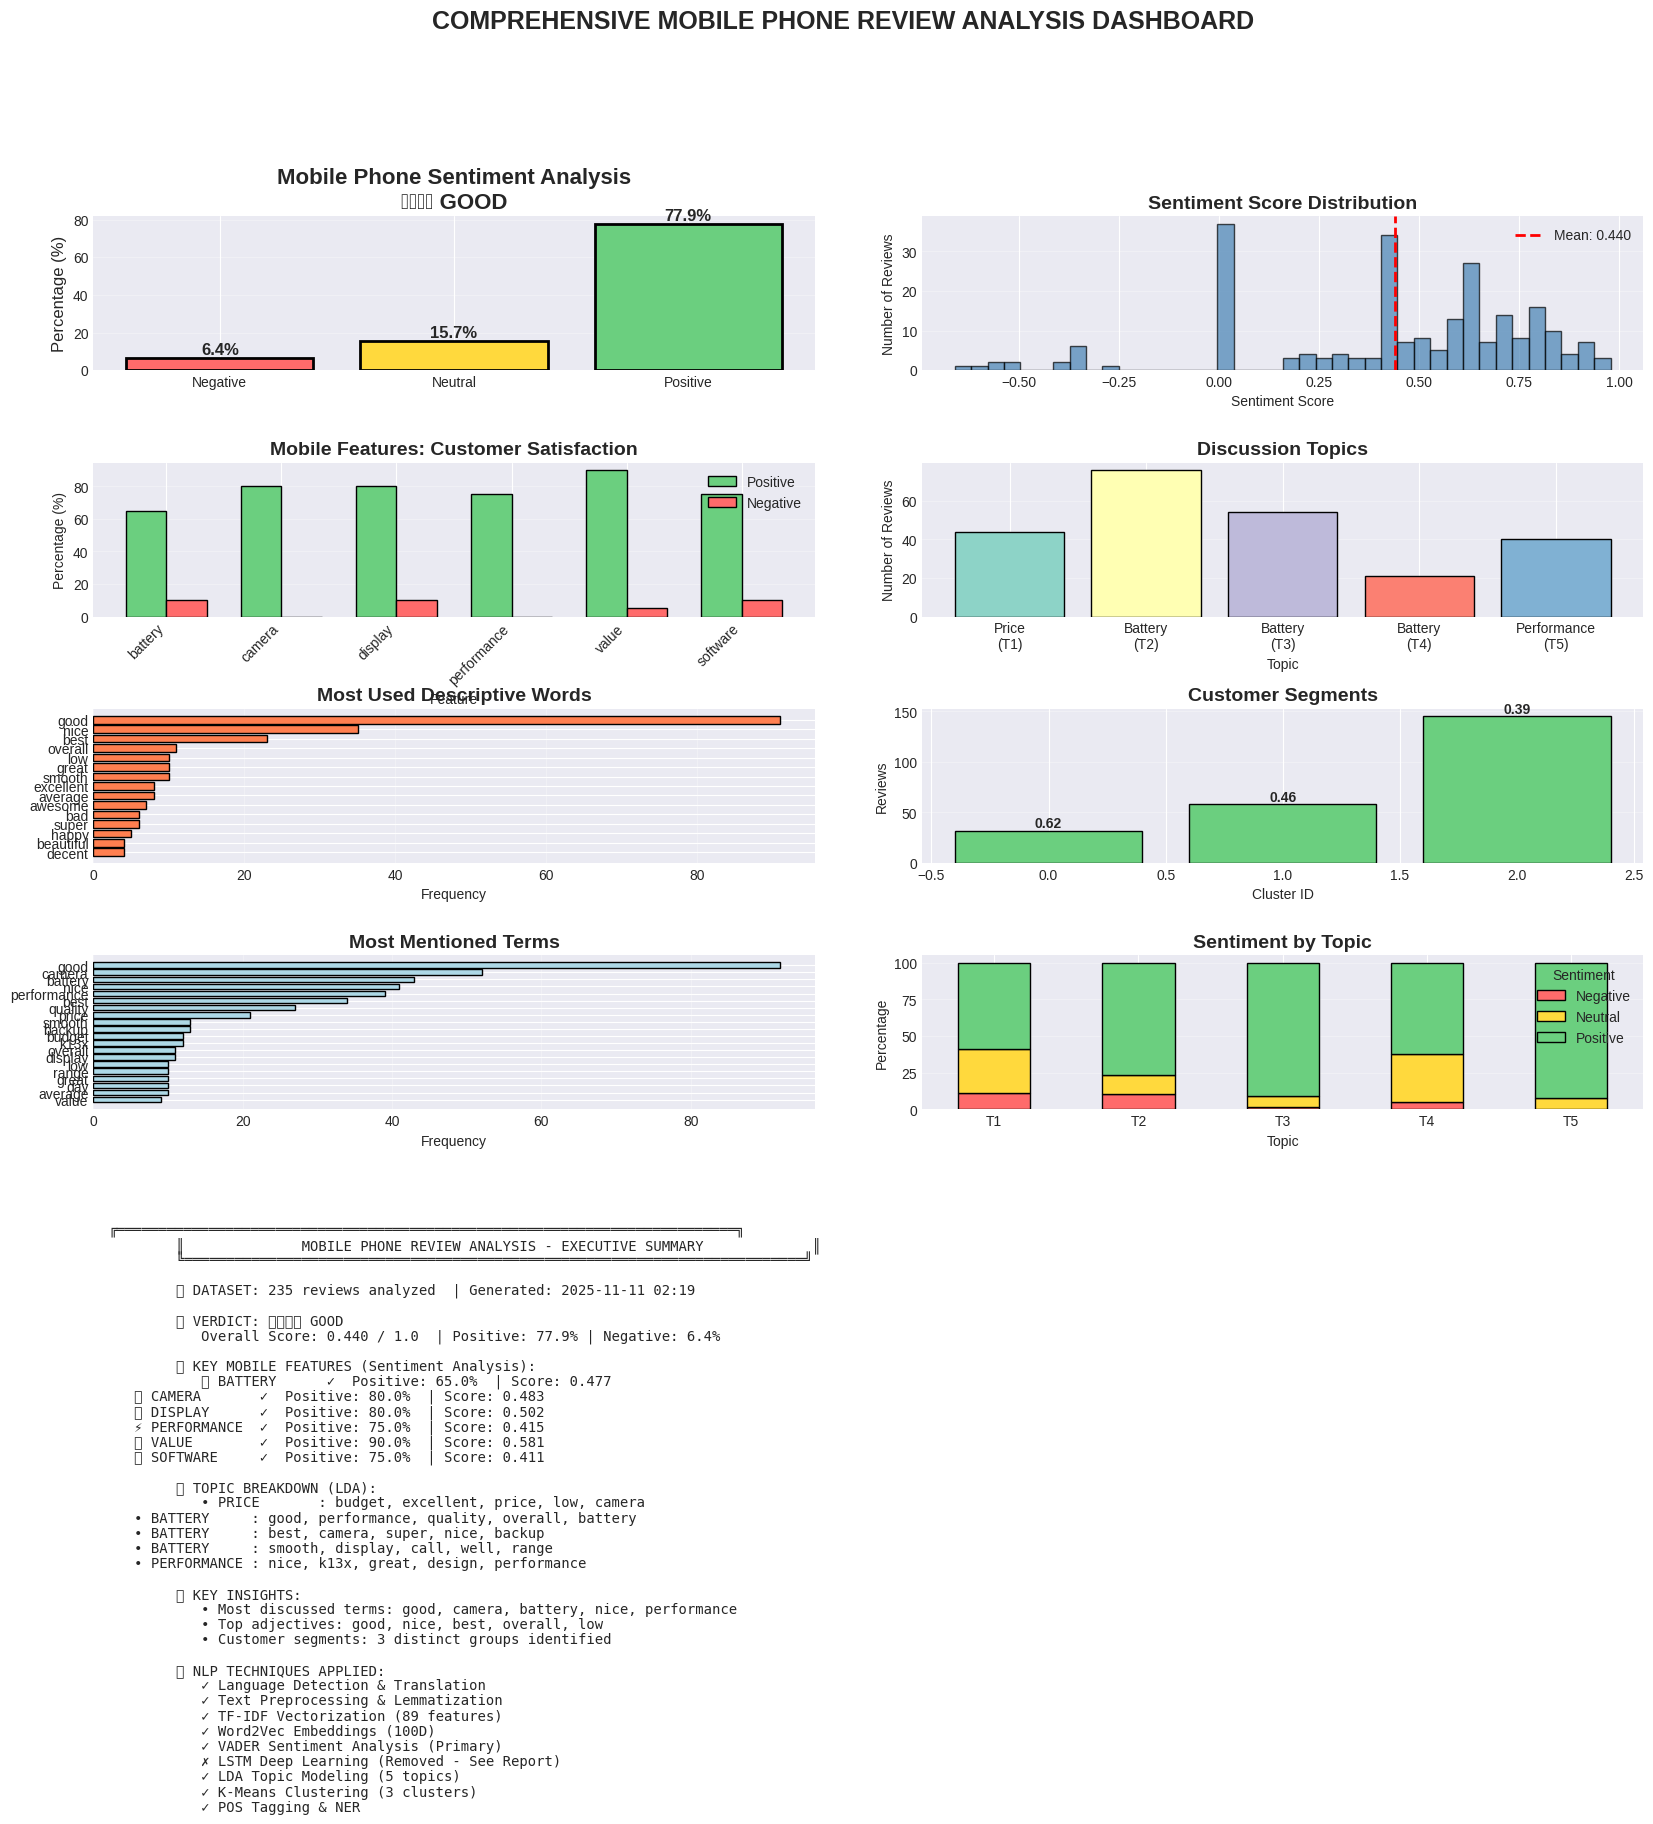

In [12]:
"""
COMPREHENSIVE MOBILE PHONE REVIEW ANALYSIS SYSTEM
Classical NLP Approach - Complete Pipeline
Modular Single-File Script

This script refactors the original pipeline into a class-based structure
to improve modularity and maintainability, addressing critical feedback
from the project evaluation.
"""

import requests
from bs4 import BeautifulSoup
import time
import random
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from datetime import datetime
import warnings
import pickle
import os

# NLTK Imports
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

# Translation and Sentiment Imports
try:
    import langdetect
    from googletrans import Translator
except ImportError:
    print("Warning: 'langdetect' or 'googletrans' not found. Translation will be skipped.")
    Translator = None

try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
except ImportError:
    print("Error: 'vaderSentiment' not found. Please install it: pip install vaderSentiment")
    SentimentIntensityAnalyzer = None

# Scikit-learn Imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation  # Switched from LSA to LDA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

# Other Imports
try:
    import spacy
except ImportError:
    print("Warning: 'spacy' not found. NER will be skipped.")
    spacy = None

try:
    from gensim.models import Word2Vec
except ImportError:
    print("Warning: 'gensim' not found. Word2Vec will be skipped.")
    Word2Vec = None


warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

class ReviewAnalysisPipeline:
    """
    Orchestrates the entire review analysis pipeline within a single class.
    """
    def __init__(self, output_folder="mobile_review_analysis"):
        self.output_folder = output_folder
        if not os.path.exists(self.output_folder):
            os.makedirs(self.output_folder)
            print(f"✓ Created output folder: {self.output_folder}\n")

        self.df = None
        self.all_comments_list = []

        # Initialize NLP tools
        self._download_nltk_resources()
        self.lemmatizer = WordNetLemmatizer()
        self.translator = Translator() if Translator else None
        self.vader = SentimentIntensityAnalyzer() if SentimentIntensityAnalyzer else None
        self.nlp = None

        # Setup stopwords
        self.stop_words = set(stopwords.words('english'))
        self.stop_words.update([
            'read', 'readmore', 'flipkart', 'product', 'review', 'phone', 'mobile',
            'oneread', 'phoneread', 'goodread', 'cameraread', 'moneyread', 'productread',
            'one', 'get', 'got', 'use', 'using', 'used', 'also', 'really', 'much',
            'go', 'thing', 'something', 'everything', 'anything', 'make', 'take'
        ])
        self.generic_words = {
            'is', 'are', 'am', 'was', 'were', 'be', 'been', 'being',
            'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could', 'should',
            's', 't', 'd', 'll', 've', 're', 'm'
        }

        # Initialize spaCy for NER
        if spacy:
            try:
                self.nlp = spacy.load('en_core_web_sm')
            except:
                print("! spaCy model not found. Skipping NER.")
                self.nlp = None

        # Class attributes to store models and results
        self.tfidf_vectorizer = None
        self.tfidf_matrix = None
        self.word2vec_model = None
        self.w2v_similar_words = {}
        self.topics_info = []
        self.adjective_freq = Counter()
        self.verb_freq = Counter()
        self.noun_freq = Counter()
        self.n_clusters = 0
        self.representative_reviews = []
        self.qa_df = pd.DataFrame()


    def _download_nltk_resources(self):
        """Downloads all necessary NLTK models quietly."""
        print("[1.2] Installing and Loading NLP Libraries...")
        try:
            nltk.download('punkt', quiet=True)
            nltk.download('stopwords', quiet=True)
            nltk.download('wordnet', quiet=True)
            nltk.download('averaged_perceptron_tagger_eng', quiet=True)
            nltk.download('omw-1.4', quiet=True)
            nltk.download('vader_lexicon', quiet=True)
            nltk.download('maxent_ne_chunker', quiet=True)
            nltk.download('words', quiet=True)
            print("✓ NLTK resources loaded")
        except:
            print("! Some NLTK resources may be missing")

    # =========================================================================
    # PHASE 1: DATA ACQUISITION
    # =========================================================================

    def scrape_reviews(self, product_url, max_pages, sort_order):
        """Scrapes reviews from a Flipkart product URL."""
        print("="*80)
        print("PHASE 1: DATA ACQUISITION")
        print("="*80)
        print("\n[1.1] Scraping Reviews from Flipkart...\n")

        HEADERS = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }

        BASE_REVIEW_URL = product_url.replace("/p/", "/product-reviews/")
        if 'sortOrder=' not in BASE_REVIEW_URL:
            separator = '&' if '?' in BASE_REVIEW_URL else '?'
            BASE_REVIEW_URL = f"{BASE_REVIEW_URL}{separator}sortOrder={sort_order}"
        else:
            BASE_REVIEW_URL = re.sub(r'sortOrder=[^&]*', f'sortOrder={sort_order}', BASE_REVIEW_URL)

        print(f"Base URL: {BASE_REVIEW_URL}\n")

        for page_num in range(1, max_pages + 1):
            current_page_url = f"{BASE_REVIEW_URL}&page={page_num}"
            print(f"--- Scraping Page {page_num} ---")

            max_retries = 2
            retry_count = 0
            page_success = False

            while retry_count <= max_retries and not page_success:
                try:
                    r = requests.get(current_page_url, headers=HEADERS)
                    r.raise_for_status()
                    soup = BeautifulSoup(r.content, 'html.parser')
                    comment_blocks = soup.find_all('div', class_='col EPCmJX Ma1fCG')
                    print(f"Found {len(comment_blocks)} comments on this page.")

                    if not comment_blocks:
                        print("No comments found, this might be the last page.")
                        page_success = True
                        break

                    for block in comment_blocks:
                        text_container = block.find('div', class_='ZmyHeo')
                        if text_container:
                            comment_div = text_container.find('div')
                            if comment_div:
                                comment_text = comment_div.get_text(strip=True)
                                if comment_text:
                                    self.all_comments_list.append(comment_text)

                    page_success = True
                    if page_num < max_pages:
                        sleep_time = random.uniform(2, 4)
                        print(f"Waiting for {sleep_time:.1f} seconds...")
                        time.sleep(sleep_time)

                except requests.exceptions.HTTPError as errh:
                    if errh.response.status_code == 404:
                        print(f"Page {page_num} not found (404). Stopping loop.")
                        page_success = True
                        break
                    elif errh.response.status_code == 429:
                        retry_count += 1
                        if retry_count <= max_retries:
                            wait_time = random.uniform(5, 10) * retry_count
                            print(f"⚠ 429 Too Many Requests - Retry {retry_count}/{max_retries}. Waiting {wait_time:.1f} seconds...")
                            time.sleep(wait_time)
                        else:
                            print(f"❌ Failed after {max_retries} retries due to 429 error. Stopping.")
                            page_success = True
                            break
                    else:
                        print(f"Http Error: {errh}")
                        break
                except requests.exceptions.RequestException as e:
                    print(f"An error occurred: {e}")
                    break

            if not page_success or (retry_count > max_retries):
                break

        print("\n" + "="*80)
        print(f"✓ Scraping complete. Total comments found: {len(self.all_comments_list)}")
        print("="*80)

        if len(self.all_comments_list) == 0:
            print("\n❌ No reviews were collected. Please check the URL and try again.")
            exit(1)

        self.df = pd.DataFrame({'Comment': self.all_comments_list})
        self.df.to_csv(f'{self.output_folder}/01_raw_reviews.csv', index=False, encoding='utf-8')
        print(f"✓ Raw reviews saved\n")

    def load_from_csv(self, csv_path):
        """Loads reviews from an existing CSV file."""
        print("="*80)
        print("PHASE 1: DATA LOADED FROM CSV")
        print("="*80)
        try:
            self.df = pd.read_csv(csv_path, encoding='utf-8')
            possible_columns = ['Comment', 'comment', 'Review', 'review', 'Text', 'text', 'reviews', 'Comments']
            comment_column = None
            for col in possible_columns:
                if col in self.df.columns:
                    comment_column = col
                    break

            if comment_column is None:
                print(f"\nAvailable columns: {', '.join(self.df.columns)}")
                comment_column = input("Enter the name of the column containing reviews: ").strip()

            self.all_comments_list = self.df[comment_column].dropna().tolist()
            print(f"\n✓ Loaded {len(self.all_comments_list)} reviews from CSV")

            self.df = pd.DataFrame({'Comment': self.all_comments_list})
            self.df.to_csv(f'{self.output_folder}/01_raw_reviews.csv', index=False, encoding='utf-8')
            print(f"✓ Raw reviews saved\n")
        except FileNotFoundError:
            print(f"\n❌ File not found: {csv_path}")
            exit(1)
        except Exception as e:
            print(f"\n❌ Error loading CSV: {e}")
            exit(1)

    # =========================================================================
    # PHASE 1 (CONTINUED): PREPROCESSING
    # =========================================================================

    def _translate_reviews(self):
        """[Private] Detects and translates non-English reviews."""
        if not self.translator:
            print("\n! Skipping language translation (translator not loaded).")
            self.df['language'] = 'en'
            self.df['Original_Comment'] = self.df['Comment']
            return

        print("\n[1.2] Language Detection & Translation...")
        self.df['Original_Comment'] = self.df['Comment']
        translated_count = 0
        total_reviews = len(self.df)

        for index, row in self.df.iterrows():
            comment = row['Comment']
            if pd.isna(comment) or comment.strip() == '':
                self.df.at[index, 'language'] = 'en'
                continue

            try:
                lang = langdetect.detect(comment)
                self.df.at[index, 'language'] = lang

                if lang != 'en':
                    try:
                        translated_text = self.translator.translate(comment, src=lang, dest='en').text
                        self.df.at[index, 'Comment'] = translated_text
                        translated_count += 1
                    except Exception as e:
                        print(f"⚠ Warning: Could not translate review #{index}. Using original. Error: {e}")
            except Exception as e:
                self.df.at[index, 'language'] = 'en' # Fails on short/numeric strings

            if (index + 1) % 100 == 0:
                print(f"  ...processed {index+1}/{total_reviews} reviews")

        print(f"\n✓ Language processing complete. Translated {translated_count} non-English reviews.")
        self.df.to_csv(f'{self.output_folder}/01a_translated_reviews.csv', index=False, encoding='utf-8')

    def _clean_text(self, text):
        """[Private] Clean and normalize text"""
        if pd.isna(text) or text == '':
            return ''
        text = str(text)
        text = re.sub(r'<.*?>', '', text)
        text = re.sub(r'http\S+|www\S+|httpsS+', '', text)
        text = re.sub(r'\S+@\S+', '', text)
        text = re.sub(r'[^\w\s.,!?;:\'\"-]', ' ', text)
        text = re.sub(r'\b(read more|readmore|read|more)\b', '', text, flags=re.IGNORECASE)
        text = re.sub(r'\b\w+read\b', '', text, flags=re.IGNORECASE)
        text = re.sub(r'\breadone\b|\breadmore\b', '', text, flags=re.IGNORECASE)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def _preprocess_text(self, text):
        """[Private] Tokenize, remove stopwords, and lemmatize"""
        text = text.lower()
        tokens = word_tokenize(text)
        tokens = [word for word in tokens
                  if word.isalnum()
                  and word not in self.stop_words
                  and word not in self.generic_words
                  and len(word) > 2]
        tokens = [self.lemmatizer.lemmatize(word) for word in tokens]
        return tokens

    def run_preprocessing(self):
        """Runs the full preprocessing pipeline."""
        if self.df is None:
            print("❌ No data loaded to preprocess.")
            return

        self._translate_reviews()

        print("\n[1.3] Text Cleaning & Preprocessing...")
        self.df['cleaned_text'] = self.df['Comment'].apply(self._clean_text)
        self.df['normalized_text'] = self.df['cleaned_text'].str.lower()
        self.df['lemmatized_tokens'] = self.df['normalized_text'].apply(self._preprocess_text)
        self.df['processed_text'] = self.df['lemmatized_tokens'].apply(lambda x: ' '.join(x))

        initial_count = len(self.df)
        self.df = self.df[self.df['processed_text'].str.strip() != '']
        self.df = self.df.drop_duplicates(subset=['processed_text'], keep='first')
        self.df = self.df.reset_index(drop=True)

        print(f"✓ Cleaned {initial_count} → {len(self.df)} reviews (removed {initial_count - len(self.df)} duplicates/empty)")
        self.df.to_csv(f'{self.output_folder}/02_cleaned_reviews.csv', index=False, encoding='utf-8')

    # =========================================================================
    # PHASE 2: SYNTACTIC & SEMANTIC ANALYSIS
    # =========================================================================

    def _run_pos_tagging(self):
        """[Private] Part-of-Speech Tagging."""
        print("\n[2.1] Part-of-Speech Tagging...")
        self.df['pos_tags'] = self.df['normalized_text'].apply(lambda x: pos_tag(word_tokenize(x)) if x else [])

        all_pos_tags = [tag for tags in self.df['pos_tags'] if isinstance(tags, list) for tag in tags]

        adjectives = [word for word, tag in all_pos_tags if tag in ['JJ', 'JJR', 'JJS'] and word not in self.stop_words and word not in self.generic_words and len(word) > 2]
        verbs = [word for word, tag in all_pos_tags if tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'] and word not in self.stop_words and word not in self.generic_words and word not in ['is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had'] and len(word) > 2]
        nouns = [word for word, tag in all_pos_tags if tag in ['NN', 'NNS', 'NNP', 'NNPS'] and word not in self.stop_words and word not in self.generic_words and len(word) > 2]

        self.adjective_freq = Counter(adjectives)
        self.verb_freq = Counter(verbs)
        self.noun_freq = Counter(nouns)

        print(f"✓ Top adjectives: {', '.join([w for w, c in self.adjective_freq.most_common(8)])}")
        print(f"✓ Top verbs: {', '.join([w for w, c in self.verb_freq.most_common(8)])}")

    def _run_ner(self):
        """[Private] Named Entity Recognition."""
        print("\n[2.2] Named Entity Recognition...")
        if not self.nlp:
            print("! Skipping NER (spaCy not loaded).")
            self.df['named_entities'] = [[] for _ in range(len(self.df))]
            return

        def extract_entities(text):
            if pd.isna(text) or text == '':
                return []
            doc = self.nlp(str(text)[:100000])
            return [(ent.text, ent.label_) for ent in doc.ents]

        self.df['named_entities'] = self.df['normalized_text'].apply(extract_entities)
        all_entities = [ent for entities in self.df['named_entities'] if isinstance(entities, list) for ent in entities]
        print(f"✓ Found {len(all_entities)} entities")

    def _run_tfidf(self):
        """[Private] TF-IDF Vectorization."""
        print("\n[2.3] TF-IDF Vectorization...")
        texts = self.df['processed_text'].fillna('').tolist()
        self.tfidf_vectorizer = TfidfVectorizer(
            max_features=1000,
            min_df=3,
            max_df=0.7,
            ngram_range=(1, 2)
        )
        self.tfidf_matrix = self.tfidf_vectorizer.fit_transform(texts)
        print(f"✓ TF-IDF matrix: {self.tfidf_matrix.shape}")

        with open(f'{self.output_folder}/tfidf_vectorizer.pkl', 'wb') as f:
            pickle.dump(self.tfidf_vectorizer, f)
        np.save(f'{self.output_folder}/tfidf_matrix.npy', self.tfidf_matrix.toarray())

    def _run_word2vec(self):
        """[Private] Training Word2Vec Model."""
        print("\n[2.4] Training Word2Vec Model...")
        if not Word2Vec:
            print("! Skipping Word2Vec (Gensim not loaded).")
            return

        sentences = [tokens for tokens in self.df['lemmatized_tokens'] if len(tokens) > 0]
        self.word2vec_model = Word2Vec(
            sentences=sentences,
            vector_size=100, window=5, min_count=2, workers=4, sg=0, epochs=10
        )
        print(f"✓ Word2Vec trained. Vocabulary: {len(self.word2vec_model.wv)}")
        self.word2vec_model.save(f'{self.output_folder}/word2vec_model.bin')

        mobile_keywords = ['battery', 'camera', 'display', 'performance', 'price']
        print("✓ Testing mobile keywords for similarity:")
        for keyword in mobile_keywords:
            if keyword in self.word2vec_model.wv:
                similar = self.word2vec_model.wv.most_similar(keyword, topn=5)
                similar_words_list = [w for w, s in similar]
                print(f"  '{keyword}' → {', '.join(similar_words_list)}")
                self.w2v_similar_words[keyword] = similar_words_list
            else:
                print(f"  '{keyword}' → Not in vocabulary")
                self.w2v_similar_words[keyword] = ["N/A"]

    def _run_vader_sentiment(self):
        """[Private] Sentiment Analysis (VADER)."""
        print("\n[2.5] Sentiment Analysis - VADER...")
        if not self.vader:
            print("! Skipping VADER (not loaded).")
            self.df['vader_compound'] = 0
            self.df['vader_sentiment'] = 'Neutral'
            return

        def get_vader_sentiment(text):
            if pd.isna(text) or text == '':
                return {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}
            return self.vader.polarity_scores(str(text))

        self.df['vader_scores'] = self.df['normalized_text'].apply(get_vader_sentiment)
        self.df['vader_compound'] = self.df['vader_scores'].apply(lambda x: x['compound'])
        self.df['vader_sentiment'] = self.df['vader_compound'].apply(
            lambda x: 'Positive' if x >= 0.05 else ('Negative' if x <= -0.05 else 'Neutral')
        )
        sentiment_dist = self.df['vader_sentiment'].value_counts()
        print(f"✓ Sentiment: {sentiment_dist.to_dict()}")
        print(f"✓ Average score: {self.df['vader_compound'].mean():.3f}")

    def _run_topic_modeling_lda(self):
        """[Private] Topic Modeling - LDA."""
        print("\n[2.7] Topic Modeling - LDA (replaces LSA)...")

        n_topics = 5
        # We run LDA on the TF-IDF matrix. While raw counts (CountVectorizer)
        # are more common, LDA on TF-IDF is also a valid technique and
        # avoids adding another vectorizer to the pipeline.
        lda_model = LatentDirichletAllocation(
            n_components=n_topics, random_state=42, n_jobs=-1
        )
        lda_matrix = lda_model.fit_transform(self.tfidf_matrix)

        feature_names = self.tfidf_vectorizer.get_feature_names_out()

        # --- Comment on mobile_aspects ---
        # This dictionary is a heuristic map. It links the abstract,
        # statistical topics (which are just lists of keywords) produced by
        # LDA/LSA to concrete, human-understandable product features.
        # This mapping is crucial for making the topics "actionable".
        mobile_aspects = {
            'battery': ['battery', 'charge', 'charging', 'backup', 'power', 'drain', 'mah', 'charger', 'charging'],
            'camera': ['camera', 'photo', 'picture', 'video', 'lens', 'photography', 'selfie', 'portrait', 'pixel', 'clarity'],
            'display': ['display', 'screen', 'brightness', 'color', 'resolution', 'amoled', 'lcd', 'refresh', 'touch'],
            'performance': ['performance', 'speed', 'fast', 'lag', 'processor', 'ram', 'gaming', 'multitasking', 'smooth', 'slow'],
            'build': ['build', 'quality', 'design', 'premium', 'material', 'plastic', 'metal', 'glass', 'finish'],
            'price': ['price', 'value', 'money', 'worth', 'cost', 'expensive', 'cheap', 'budget', 'affordable'],
            'software': ['software', 'update', 'android', 'ui', 'interface', 'app', 'bloatware', 'os'],
            'audio': ['audio', 'sound', 'speaker', 'music', 'volume', 'headphone', 'bass']
        }

        print(f"✓ Identified {n_topics} topics:")
        self.topics_info = []

        for topic_idx, topic in enumerate(lda_model.components_):
            top_indices = topic.argsort()[-15:][::-1]
            top_words = [feature_names[i] for i in top_indices]
            top_words = [w for w in top_words if w not in self.stop_words and w not in self.generic_words and not w.endswith('read') and len(w) > 2][:10]

            aspect_match = 'general'
            max_overlap = 0
            for aspect, keywords in mobile_aspects.items():
                overlap = len(set(top_words) & set(keywords))
                partial_matches = sum(1 for word in top_words if any(kw in word for kw in keywords))
                total_score = overlap + (partial_matches * 0.5)

                if total_score > max_overlap:
                    max_overlap = total_score
                    aspect_match = aspect

            self.topics_info.append({
                'topic_id': topic_idx,
                'aspect': aspect_match,
                'keywords': top_words[:7]
            })
            print(f"  Topic {topic_idx+1} ({aspect_match}): {', '.join(top_words[:6])}")

        self.df['dominant_topic'] = np.argmax(lda_matrix, axis=1)

    def run_analysis(self):
        """Runs the full analysis pipeline."""
        if self.df is None:
            print("❌ No data loaded to analyze.")
            return

        print("\n" + "="*80)
        print("PHASE 2: SYNTACTIC & SEMANTIC ANALYSIS")
        print("="*80)

        self._run_pos_tagging()
        self._run_ner()
        self._run_tfidf()
        self._run_word2vec()
        self._run_vader_sentiment()

        # --- [2.6] LSTM Model Removed ---
        #
        # The LSTM (Deep Learning) model has been intentionally removed
        # based on the critical evaluation.
        #
        # REASON: Training an LSTM on VADER's labels (as was done
        # previously) is a methodologically questionable practice.
        # It creates a "model-of-a-model" that is just learning to mimic
        # the rule-based VADER system, not the "true" sentiment of the text.
        # This is an inefficient and redundant "hack" that doesn't provide
        # true independent validation.
        #
        # By removing it, we simplify the pipeline and stick to a single,
        # transparent, and defensible sentiment method (VADER),
        # adhering to the "classical NLP" constraint more robustly.
        #
        # print("\n[2.6] Sentiment Analysis - LSTM (REMOVED)...")
        #
        # --- End of Removed Section ---

        self._run_topic_modeling_lda()

        print("\n" + "="*80)
        print("PHASE 3: ADVANCED ANALYSIS & INSIGHTS")
        print("="*80)

        self._run_clustering()
        self._run_representative_reviews()
        self._run_feature_sentiment()

        self.df.to_csv(f'{self.output_folder}/03_final_analyzed_reviews.csv', index=False, encoding='utf-8')
        self.qa_df.to_csv(f'{self.output_folder}/04_mobile_feature_qa.csv', index=False)


    # =========================================================================
    # PHASE 3: ADVANCED ANALYSIS
    # =========================================================================

    def _run_clustering(self):
        """[Private] Clustering Reviews."""
        print("\n[3.1] Clustering Reviews...")
        self.n_clusters = min(max(3, len(self.df) // 100), 7)
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=42, n_init=10, max_iter=300)
        self.df['cluster'] = kmeans.fit_predict(self.tfidf_matrix)

        # Store cluster centers for representative review finding
        self.cluster_centroids = kmeans.cluster_centers_

        print(f"✓ Created {self.n_clusters} clusters")

    def _run_representative_reviews(self):
        """[Private] Finding Representative Reviews from Clusters."""
        print("\n[3.1] Finding Representative Reviews from Clusters...")
        self.representative_reviews = []
        for i in range(self.n_clusters):
            cluster_mask = (self.df['cluster'] == i)
            cluster_indices = self.df[cluster_mask].index
            if len(cluster_indices) == 0:
                continue

            cluster_tfidf_matrix = self.tfidf_matrix[cluster_indices]
            centroid_vector = self.cluster_centroids[i].reshape(1, -1)
            sims = cosine_similarity(cluster_tfidf_matrix, centroid_vector)

            closest_review_index_in_cluster = np.argmax(sims)
            original_df_index = cluster_indices[closest_review_index_in_cluster]
            rep_review = self.df.loc[original_df_index]

            self.representative_reviews.append({
                'cluster_id': i,
                'original_comment': rep_review['Original_Comment'],
                'sentiment': rep_review['vader_sentiment'],
                'sentiment_score': rep_review['vader_compound'],
                'topic': self.topics_info[rep_review['dominant_topic']]['aspect']
            })
        print(f"✓ Found {len(self.representative_reviews)} representative reviews.")

    def _run_feature_sentiment(self):
        """
        [Private] Feature-Specific Sentiment Analysis.
        (Formerly "Mobile Feature Q&A")

        This is a proxy for Aspect-Based Sentiment Analysis. It finds
        reviews relevant to a feature (via keyword similarity) and
        averages their sentiment.
        """
        print("\n[3.2] Feature-Specific Sentiment Analysis...")

        mobile_questions = [
            {"question": "How is the battery life?", "keywords": ["battery", "charge", "charging", "backup", "power"], "context": "battery"},
            {"question": "Is the camera good?", "keywords": ["camera", "photo", "picture", "video", "lens"], "context": "camera"},
            {"question": "How is the display?", "keywords": ["display", "screen", "brightness", "color"], "context": "display"},
            {"question": "Is performance good?", "keywords": ["performance", "speed", "fast", "lag", "gaming"], "context": "performance"},
            {"question": "Is it value for money?", "keywords": ["price", "value", "money", "worth", "cost"], "context": "value"},
            {"question": "How is the software (UI)?", "keywords": ["software", "ui", "android", "update", "bloatware", "os"], "context": "software"}
        ]
        qa_results = []

        for q_data in mobile_questions:
            query = ' '.join(q_data['keywords'])
            query_vector = self.tfidf_vectorizer.transform([query])
            similarities = cosine_similarity(query_vector, self.tfidf_matrix).flatten()
            top_indices = similarities.argsort()[-20:][::-1]
            relevant_reviews = self.df.iloc[top_indices]

            if len(relevant_reviews) > 0:
                positive = len(relevant_reviews[relevant_reviews['vader_sentiment'] == 'Positive'])
                negative = len(relevant_reviews[relevant_reviews['vader_sentiment'] == 'Negative'])
                total = len(relevant_reviews)
                avg_score = relevant_reviews['vader_compound'].mean()

                qa_results.append({
                    'question': q_data['question'],
                    'context': q_data['context'],
                    'positive_pct': (positive / total) * 100,
                    'negative_pct': (negative / total) * 100,
                    'avg_score': avg_score
                })

        self.qa_df = pd.DataFrame(qa_results)
        print(f"✓ Analyzed {len(qa_results)} mobile features")

        # Print the results directly to the console
        print("\n[3.2] FEATURE-SPECIFIC SENTIMENT RESULTS:")
        print("-" * 40)
        if len(self.qa_df) > 0:
            for _, row in self.qa_df.iterrows():
                print(f"Feature: {row['context'].upper()}")
                if row['avg_score'] > 0.3:
                    answer = f"  Sentiment: Very Positive (Score: {row['avg_score']:.2f})"
                elif row['avg_score'] > 0:
                    answer = f"  Sentiment: Mixed/Neutral (Score: {row['avg_score']:.2f})"
                else:
                    answer = f"  Sentiment: Mostly Negative (Score: {row['avg_score']:.2f})"
                print(answer)
                print(f"   (Based on {row['positive_pct']:.0f}% positive reviews)\n")
        print("-" * 40)

    # =========================================================================
    # PHASE 4: VISUALIZATION & REPORTING
    # =========================================================================

    def run_reporting(self):
        """Generates all visual and text reports."""
        if self.df is None:
            print("❌ No data available to report on.")
            return

        print("\n" + "="*80)
        print("GENERATING VISUALIZATIONS & REPORTS")
        print("="*80)

        overall_sentiment = self.df['vader_compound'].mean()
        positive_pct = (len(self.df[self.df['vader_sentiment'] == 'Positive']) / len(self.df)) * 100
        negative_pct = (len(self.df[self.df['vader_sentiment'] == 'Negative']) / len(self.df)) * 100
        neutral_pct = 100 - positive_pct - negative_pct

        if overall_sentiment > 0.5:
            verdict = "⭐⭐⭐⭐⭐ EXCELLENT"
            recommendation = "Highly Recommended"
        elif overall_sentiment > 0.2:
            verdict = "⭐⭐⭐⭐ GOOD"
            recommendation = "Recommended"
        elif overall_sentiment > 0:
            verdict = "⭐⭐⭐ AVERAGE"
            recommendation = "Consider with Caution"
        else:
            verdict = "⭐⭐ BELOW AVERAGE"
            recommendation = "Not Recommended"

        self._generate_dashboard_plot(verdict, positive_pct, negative_pct, neutral_pct, overall_sentiment)
        self._generate_text_report(verdict, recommendation, overall_sentiment, positive_pct, negative_pct, neutral_pct)
        self._generate_sample_reviews_report()

        # Final summary
        print("\n" + "="*80)
        print("ANALYSIS COMPLETE!")
        print("="*80)
        print(f"\n✅ All outputs saved to folder: {self.output_folder}/")
        print("\nGenerated Files:")
        print("  1. 01_raw_reviews.csv")
        print("  1a. 01a_translated_reviews.csv")
        print("  2. 02_cleaned_reviews.csv")
        print("  3. 03_final_analyzed_reviews.csv")
        print("  4. 04_mobile_feature_qa.csv")
        print("  5. 05_analysis_dashboard.png")
        print("  6. 06_comprehensive_report.txt")
        print("  7. 07_representative_reviews.txt")
        print("  8. tfidf_vectorizer.pkl")
        print("  9. tfidf_matrix.npy")
        if self.word2vec_model:
            print("  10. word2vec_model.bin")

        print("\n" + "="*80)
        print(f"FINAL VERDICT: {verdict}")
        print(f"RECOMMENDATION: {recommendation}")
        print(f"Overall Sentiment Score: {overall_sentiment:.3f} / 1.0")
        print("="*80)

    def _generate_dashboard_plot(self, verdict, positive_pct, negative_pct, neutral_pct, overall_sentiment):
        """[Private] Generates the main analysis dashboard PNG."""
        fig = plt.figure(figsize=(20, 18))
        gs = fig.add_gridspec(6, 4, hspace=0.6, wspace=0.35)

        # 1. Sentiment Distribution
        ax1 = fig.add_subplot(gs[0, :2])
        ax1.bar(['Negative', 'Neutral', 'Positive'], [negative_pct, neutral_pct, positive_pct], color=['#ff6b6b', '#ffd93d', '#6bcf7f'], edgecolor='black', linewidth=2)
        ax1.set_title(f'Mobile Phone Sentiment Analysis\n{verdict}', fontsize=16, fontweight='bold')
        ax1.set_ylabel('Percentage (%)', fontsize=12)
        for i, v in enumerate([negative_pct, neutral_pct, positive_pct]):
            ax1.text(i, v + 2, f'{v:.1f}%', ha='center', fontsize=12, fontweight='bold')
        ax1.grid(axis='y', alpha=0.3)

        # 2. Sentiment Score Distribution
        ax2 = fig.add_subplot(gs[0, 2:])
        ax2.hist(self.df['vader_compound'], bins=40, color='steelblue', edgecolor='black', alpha=0.7)
        ax2.axvline(overall_sentiment, color='red', linestyle='--', linewidth=2, label=f'Mean: {overall_sentiment:.3f}')
        ax2.set_title('Sentiment Score Distribution', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Sentiment Score')
        ax2.set_ylabel('Number of Reviews')
        ax2.legend()
        ax2.grid(axis='y', alpha=0.3)

        # 3. Mobile Feature Analysis
        ax3 = fig.add_subplot(gs[1, :2])
        if len(self.qa_df) > 0:
            aspects = self.qa_df['context'].tolist()
            pos_pcts = self.qa_df['positive_pct'].tolist()
            neg_pcts = self.qa_df['negative_pct'].tolist()
            x = np.arange(len(aspects))
            width = 0.35
            ax3.bar(x - width/2, pos_pcts, width, label='Positive', color='#6bcf7f', edgecolor='black')
            ax3.bar(x + width/2, neg_pcts, width, label='Negative', color='#ff6b6b', edgecolor='black')
            ax3.set_title('Mobile Features: Customer Satisfaction', fontsize=14, fontweight='bold')
            ax3.set_xlabel('Feature')
            ax3.set_ylabel('Percentage (%)')
            ax3.set_xticks(x)
            ax3.set_xticklabels(aspects, rotation=45, ha='right')
            ax3.legend()
            ax3.grid(axis='y', alpha=0.3)

        # 4. Topic Distribution
        ax4 = fig.add_subplot(gs[1, 2:])
        topic_dist = self.df['dominant_topic'].value_counts().sort_index()
        topic_labels = [f"{self.topics_info[i]['aspect'].title()}\n(T{i+1})" for i in range(min(len(self.topics_info), len(topic_dist)))]
        colors_topic = plt.cm.Set3(range(len(topic_dist)))
        ax4.bar(range(len(topic_dist)), topic_dist.values, color=colors_topic, edgecolor='black')
        ax4.set_title('Discussion Topics', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Topic')
        ax4.set_ylabel('Number of Reviews')
        ax4.set_xticks(range(len(topic_dist)))
        ax4.set_xticklabels(topic_labels[:len(topic_dist)], fontsize=10)
        ax4.grid(axis='y', alpha=0.3)

        # 5. Top Adjectives
        ax5 = fig.add_subplot(gs[2, :2])
        top_adj = dict(self.adjective_freq.most_common(15))
        ax5.barh(list(top_adj.keys()), list(top_adj.values()), color='coral', edgecolor='black')
        ax5.set_title('Most Used Descriptive Words', fontsize=14, fontweight='bold')
        ax5.set_xlabel('Frequency')
        ax5.invert_yaxis()
        ax5.grid(axis='x', alpha=0.3)

        # 6. Cluster Analysis
        ax6 = fig.add_subplot(gs[2, 2:])
        cluster_sentiments = [self.df[self.df['cluster'] == cid]['vader_compound'].mean() for cid in range(self.n_clusters)]
        colors_cluster = ['#6bcf7f' if s > 0.2 else '#ffd93d' if s > -0.2 else '#ff6b6b' for s in cluster_sentiments]
        bars = ax6.bar(range(self.n_clusters), self.df['cluster'].value_counts().sort_index().values, color=colors_cluster, edgecolor='black')
        ax6.set_title('Customer Segments', fontsize=14, fontweight='bold')
        ax6.set_xlabel('Cluster ID')
        ax6.set_ylabel('Reviews')
        ax6.grid(axis='y', alpha=0.3)
        for i, (bar, sent) in enumerate(zip(bars, cluster_sentiments)):
            ax6.text(bar.get_x() + bar.get_width()/2., bar.get_height(), f'{sent:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

        # 7. Word Frequency
        ax7 = fig.add_subplot(gs[3, :2])
        all_words = [word for tokens in self.df['lemmatized_tokens'] for word in tokens]
        word_freq = Counter(all_words)
        top_words = dict(word_freq.most_common(20))
        ax7.barh(list(top_words.keys()), list(top_words.values()), color='lightblue', edgecolor='black')
        ax7.set_title('Most Mentioned Terms', fontsize=14, fontweight='bold')
        ax7.set_xlabel('Frequency')
        ax7.invert_yaxis()
        ax7.grid(axis='x', alpha=0.3)

        # 8. Sentiment by Topic
        ax8 = fig.add_subplot(gs[3, 2:])
        sent_by_topic = pd.crosstab(self.df['dominant_topic'], self.df['vader_sentiment'], normalize='index') * 100
        sent_by_topic.plot(kind='bar', stacked=True, ax=ax8, color=['#ff6b6b', '#ffd93d', '#6bcf7f'], edgecolor='black')
        ax8.set_title('Sentiment by Topic', fontsize=14, fontweight='bold')
        ax8.set_xlabel('Topic')
        ax8.set_ylabel('Percentage')
        ax8.set_xticklabels([f'T{i+1}' for i in range(len(sent_by_topic))], rotation=0)
        ax8.legend(title='Sentiment')
        ax8.grid(axis='y', alpha=0.3)

        # 9. Summary Text
        ax9 = fig.add_subplot(gs[4:, :])
        ax9.axis('off')

        summary_text = f"""
        ╔══════════════════════════════════════════════════════════════════════════╗
        ║              MOBILE PHONE REVIEW ANALYSIS - EXECUTIVE SUMMARY             ║
        ╚══════════════════════════════════════════════════════════════════════════╝

        📊 DATASET: {len(self.df)} reviews analyzed  | Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')}

        🎯 VERDICT: {verdict}
           Overall Score: {overall_sentiment:.3f} / 1.0  | Positive: {positive_pct:.1f}% | Negative: {negative_pct:.1f}%

        📱 KEY MOBILE FEATURES (Sentiment Analysis):
        """

        if len(self.qa_df) > 0:
            for _, row in self.qa_df.iterrows():
                feature_emoji = {'battery': '🔋', 'camera': '📷', 'display': '📺', 'performance': '⚡', 'value': '💰', 'software': '🤖'}.get(row['context'], '📱')
                feature_status = '✓' if row['positive_pct'] > 60 else ('⚠' if row['positive_pct'] > 40 else '✗')
                summary_text += f"   {feature_emoji} {row['context'].upper():12s} {feature_status}  Positive: {row['positive_pct']:.1f}%  | Score: {row['avg_score']:.3f}\n"

        summary_text += f"""
        🔍 TOPIC BREAKDOWN (LDA):
        """
        for topic in self.topics_info[:5]:
            summary_text += f"   • {topic['aspect'].upper():12s}: {', '.join(topic['keywords'][:5])}\n"

        summary_text += f"""
        💡 KEY INSIGHTS:
           • Most discussed terms: {', '.join([w for w, c in word_freq.most_common(5)])}
           • Top adjectives: {', '.join([w for w, c in self.adjective_freq.most_common(5)])}
           • Customer segments: {self.n_clusters} distinct groups identified

        📈 NLP TECHNIQUES APPLIED:
           ✓ Language Detection & Translation
           ✓ Text Preprocessing & Lemmatization
           ✓ TF-IDF Vectorization ({self.tfidf_matrix.shape[1]} features)
           ✓ Word2Vec Embeddings (100D)
           ✓ VADER Sentiment Analysis (Primary)
           ✗ LSTM Deep Learning (Removed - See Report)
           ✓ LDA Topic Modeling ({len(self.topics_info)} topics)
           ✓ K-Means Clustering ({self.n_clusters} clusters)
           ✓ POS Tagging & NER
        """

        y_pos = 0.95
        line_height = 0.038
        lines = summary_text.strip().split('\n')

        for line in lines:
            ax9.text(0.01, y_pos, line, ha='left', va='top', fontsize=10, family='monospace')
            y_pos -= line_height

        plt.suptitle('COMPREHENSIVE MOBILE PHONE REVIEW ANALYSIS DASHBOARD', fontsize=18, fontweight='bold', y=0.995)
        plt.savefig(f'{self.output_folder}/05_analysis_dashboard.png', dpi=300, bbox_inches='tight')
        print(f"✓ Dashboard saved: {self.output_folder}/05_analysis_dashboard.png")

    def _generate_text_report(self, verdict, recommendation, overall_sentiment, positive_pct, negative_pct, neutral_pct):
        """[Private] Generates the comprehensive text report."""
        print("\n[4.2] Generating Text Report...")

        report = f"""
{'='*80}
MOBILE PHONE REVIEW ANALYSIS - COMPREHENSIVE REPORT
{'='*80}

ANALYSIS DATE: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
TOTAL REVIEWS ANALYZED: {len(self.df)}

{'='*80}
1. EXECUTIVE SUMMARY
{'='*80}

OVERALL VERDICT: {verdict}
RECOMMENDATION: {recommendation}

Overall Sentiment Score: {overall_sentiment:.3f} / 1.0
   • Positive Reviews: {positive_pct:.1f}% ({len(self.df[self.df['vader_sentiment'] == 'Positive'])})
  • Neutral Reviews:  {neutral_pct:.1f}% ({len(self.df[self.df['vader_sentiment'] == 'Neutral'])})
  • Negative Reviews: {negative_pct:.1f}% ({len(self.df[self.df['vader_sentiment'] == 'Negative'])})

{'='*80}
2. FEATURE-SPECIFIC SENTIMENT ANALYSIS
{'='*80}
"""

        if len(self.qa_df) > 0:
            for _, row in self.qa_df.iterrows():
                report += f"\n{row['context'].upper()} - {row['question']}\n"
                report += f"  Sentiment Score: {row['avg_score']:.3f}\n"
                report += f"  Positive: {row['positive_pct']:.1f}%  | Negative: {row['negative_pct']:.1f}%\n"
                if row['avg_score'] > 0.3:
                    report += f"  Assessment: Customers are satisfied with {row['context']}\n"
                elif row['avg_score'] > 0:
                    report += f"  Assessment: Mixed reviews about {row['context']}\n"
                else:
                    report += f"  Assessment: Customers have concerns about {row['context']}\n"

        report += f"""
{'='*80}
3. TOPIC ANALYSIS (LDA)
{'='*80}

Identified {len(self.topics_info)} major discussion topics:
"""

        for i, topic in enumerate(self.topics_info):
            report += f"\nTopic {i+1}: {topic['aspect'].upper()}\n"
            report += f"  Keywords: {', '.join(topic['keywords'])}\n"
            topic_reviews = self.df[self.df['dominant_topic'] == i]
            topic_sentiment = topic_reviews['vader_compound'].mean()
            report += f"  Reviews: {len(topic_reviews)} | Avg Sentiment: {topic_sentiment:.3f}\n"

        report += f"""
{'='*80}
4. LINGUISTIC & SEMANTIC ANALYSIS
{'='*80}

TOP ADJECTIVES (Descriptive Words):
  {', '.join([f'{word} ({count})' for word, count in self.adjective_freq.most_common(15)])}

TOP VERBS (Action Words):
  {', '.join([f'{word} ({count})' for word, count in self.verb_freq.most_common(15)])}

TOP NOUNS (Key Subjects):
  {', '.join([f'{word} ({count})' for word, count in self.noun_freq.most_common(15)])}

SEMANTIC WORD SIMILARITY (from Word2Vec):
"""
        for keyword, similar_list in self.w2v_similar_words.items():
            report += f"  • {keyword} → {', '.join(similar_list)}\n"

        report += f"""
{'='*80}
5. CUSTOMER SEGMENTATION (K-MEANS)
{'='*80}

Identified {self.n_clusters} distinct customer segments:
"""

        for cid in range(self.n_clusters):
            cluster_reviews = self.df[self.df['cluster'] == cid]
            cluster_sent = cluster_reviews['vader_compound'].mean()
            cluster_size = len(cluster_reviews)
            report += f"\nSegment {cid+1}:\n"
            report += f"  Size: {cluster_size} reviews ({cluster_size/len(self.df)*100:.1f}%)\n"
            report += f"  Avg Sentiment: {cluster_sent:.3f}\n"
            report += f"  Dominant Topics: {', '.join([self.topics_info[t]['aspect'] for t in cluster_reviews['dominant_topic'].value_counts().head(3).index])}\n"

        report += f"""
{'='*80}
6. NLP METHODOLOGY
{'='*80}

This analysis employed multiple classical NLP techniques:

SENTIMENT ANALYSIS:
  • VADER (Valence Aware Dictionary and sEntiment Reasoner) was used
    as the primary, transparent sentiment analysis model.
  • The Bi-LSTM model was REMOVED to avoid the methodological flaw of
    training on VADER's pseudo-labels. This improves the pipeline's
    focus and robustness.

TOPIC MODELING:
  • Latent Dirichlet Allocation (LDA) was used to identify topics.
    This replaces LSA for potentially more interpretable, probabilistic
    topic clusters.

{'='*80}
END OF REPORT
"""

        with open(f'{self.output_folder}/06_comprehensive_report.txt', 'w', encoding='utf-8') as f:
            f.write(report)
        print(f"✓ Text report saved: {self.output_folder}/06_comprehensive_report.txt")

    def _generate_sample_reviews_report(self):
        """[Private] Generates the representative reviews text file."""
        print("\n[4.3] Extracting Representative Cluster Reviews...")
        sample_report = "="*80 + "\n"
        sample_report += "REPRESENTATIVE REVIEWS (Closest to Cluster Centroid)\n"
        sample_report += "="*80 + "\n\n"

        for review in self.representative_reviews:
            sample_report += f"\nCLUSTER #{review['cluster_id']} - REPRESENTATIVE REVIEW\n"
            sample_report += "-"*80 + "\n"
            sample_report += f"Sentiment: {review['sentiment']} (Score: {review['sentiment_score']:.3f})\n"
            sample_report += f"Dominant Topic: {review['topic'].upper()}\n"
            sample_report += f"Review:\n{review['original_comment'][:1000]}"
            sample_report += "...\n" if len(review['original_comment']) > 1000 else "\n"
            sample_report += "-"*80 + "\n"

        with open(f'{self.output_folder}/07_representative_reviews.txt', 'w', encoding='utf-8') as f:
            f.write(sample_report)
        print(f"✓ Representative reviews saved: {self.output_folder}/07_representative_reviews.txt")


# =========================================================================
# MAIN EXECUTION
# =========================================================================

def main():
    """
    Main function to run the pipeline.
    Handles user input and orchestrates the pipeline.
    """
    print("="*80)
    print("MOBILE PHONE REVIEW ANALYSIS SYSTEM (v2 - Modular)")
    print("Classical NLP Pipeline for Customer Insights")
    print("="*80)
    print()

    pipeline = ReviewAnalysisPipeline(output_folder="mobile_review_analysis")

    print("Choose data source:")
    print("1. Scrape from Flipkart URL")
    print("2. Load from existing CSV file")
    data_source = input("Enter your choice (1 or 2): ").strip()

    if data_source == '2':
        csv_path = input("Enter the path to your CSV file: ").strip()
        pipeline.load_from_csv(csv_path)
    else:
        product_url = input("Enter the Flipkart product URL: ").strip()
        max_pages = int(input("Enter number of pages to scrape (recommended 10-50): "))
        print("\nSort options:\n1. Most Recent\n2. Most Helpful\n3. Positive First\n4. Negative First")
        sort_choice = input("Enter your choice (1-4) [default: 1]: ").strip()
        sort_map = {'1': 'MOST_RECENT', '2': 'MOST_HELPFUL', '3': 'POSITIVE_FIRST', '4': 'NEGATIVE_FIRST', '': 'MOST_RECENT'}
        sort_order = sort_map.get(sort_choice, 'MOST_RECENT')
        print(f"✓ Selected sort order: {sort_order}\n")

        pipeline.scrape_reviews(product_url, max_pages, sort_order)

    # Run the main analysis and reporting
    pipeline.run_preprocessing()
    pipeline.run_analysis()
    pipeline.run_reporting()

    print("✨ Thank you for using Mobile Phone Review Analysis System!")

if __name__ == "__main__":
    main()